In [ ]:
#|default_exp core

# Claudette's source

This is the 'literate' source code for Claudette. You can view the fully rendered version of the notebook [here](https://claudette.answer.ai/core.html), or you can clone the git repo and run the [interactive notebook](https://github.com/AnswerDotAI/claudette/blob/main/00_core.ipynb) in Jupyter. The notebook is converted the [Python module claudette/core.py](https://github.com/AnswerDotAI/claudette/blob/main/claudette/core.py) using [nbdev](https://nbdev.fast.ai/). The goal of this source code is to both create the Python module, and also to teach the reader *how* it is created, without assuming much existing knowledge about Claude's API.

Most of the time you'll see that we write some source code *first*, and then a description or discussion of it *afterwards*.

## Setup

In [ ]:
import os
# os.environ['ANTHROPIC_LOG'] = 'debug'

To print every HTTP request and response in full, uncomment the above line. This functionality is provided by Anthropic's SDK.

In [ ]:
#| export
import inspect, typing, json
from collections import abc
try: from IPython import display
except: display=None
from typing import get_type_hints
from functools import wraps

from anthropic import Anthropic, AnthropicBedrock, AnthropicVertex
from anthropic.types import (Usage, TextBlock, ServerToolUseBlock,
                             WebSearchToolResultBlock, Message, ToolUseBlock,
                             ThinkingBlock, ServerToolUsage)
from anthropic.resources import messages

import toolslm
from toolslm.funccall import *

from fastcore.meta import delegates
from fastcore.utils import *
from msglm import mk_msg_anthropic as mk_msg, mk_msgs_anthropic as mk_msgs

In [ ]:
#| hide
from nbdev import show_doc

# Used to show available models from the anthropic SDK
from anthropic.types import Model
from claudette.text_editor import *
from typing import get_args
from datetime import datetime
from pprint import pprint

import warnings

warnings.filterwarnings("ignore", message="Pydantic serializer warnings")

In [ ]:
#| export
_all_ = ['mk_msg', 'mk_msgs']

In [ ]:
#| export
empty = inspect.Parameter.empty

:::{.callout-tip}

If you're reading the rendered version of this notebook, you'll see an "Exported source" collapsible widget below. If you're reading the source notebook directly, you'll see `#| exports` at the top of the cell. These show that this piece of code will be exported into the python module that this notebook creates. No other code will be included -- any other code in this notebook is just for demonstration, documentation, and testing.

You can toggle expanding/collapsing the source code of all exported sections by using the `</> Code` menu in the top right of the rendered notebook page.

:::

In [ ]:
#| exports

model_types = {
    # Anthropic
    'claude-3-opus-20240229': 'opus',
    'claude-3-7-sonnet-20250219': 'sonnet',
    'claude-3-5-sonnet-20241022': 'sonnet-3-5',
    'claude-3-haiku-20240307': 'haiku-3',
    'claude-3-5-haiku-20241022': 'haiku-3-5',
    # AWS
    'anthropic.claude-3-opus-20240229-v1:0': 'opus',
    'anthropic.claude-3-5-sonnet-20241022-v2:0': 'sonnet',
    'anthropic.claude-3-sonnet-20240229-v1:0': 'sonnet',
    'anthropic.claude-3-haiku-20240307-v1:0': 'haiku',
    # Google
    'claude-3-opus@20240229': 'opus',
    'claude-3-5-sonnet-v2@20241022': 'sonnet',
    'claude-3-sonnet@20240229': 'sonnet',
    'claude-3-haiku@20240307': 'haiku',
}

all_models = list(model_types)

Warning: between Anthropic SDK 0.4.2 and 0.4.7 the interface to the `Model` type changed.

In [ ]:
#|hide

# Full list of models via the anthropic SDK for reference. Not all models are surfaced by Claudette.
Model

typing.Union[typing.Literal['claude-3-7-sonnet-latest', 'claude-3-7-sonnet-20250219', 'claude-3-5-haiku-latest', 'claude-3-5-haiku-20241022', 'claude-3-5-sonnet-latest', 'claude-3-5-sonnet-20241022', 'claude-3-5-sonnet-20240620', 'claude-3-opus-latest', 'claude-3-opus-20240229', 'claude-3-sonnet-20240229', 'claude-3-haiku-20240307', 'claude-2.1', 'claude-2.0'], str]

In [ ]:
#| export
models = all_models[:5]

In [ ]:
models

['claude-3-opus-20240229',
 'claude-3-7-sonnet-20250219',
 'claude-3-5-sonnet-20241022',
 'claude-3-haiku-20240307',
 'claude-3-5-haiku-20241022']

In [ ]:
#| export
models_aws = ['claude-3-5-haiku-20241022',
 'claude-3-7-sonnet-20250219',
 'anthropic.claude-3-opus-20240229-v1:0',
 'anthropic.claude-3-5-sonnet-20241022-v2:0']

In [ ]:
#| export
models_goog = ['anthropic.claude-3-sonnet-20240229-v1:0',
 'anthropic.claude-3-haiku-20240307-v1:0',
 'claude-3-opus@20240229',
 'claude-3-5-sonnet-v2@20241022',
 'claude-3-sonnet@20240229',
 'claude-3-haiku@20240307']

In [ ]:
#| exports
text_only_models = ('claude-3-5-haiku-20241022',)

In [ ]:
#| exports
has_streaming_models = set(all_models)
has_system_prompt_models = set(all_models)
has_temperature_models = set(all_models)
has_extended_thinking_models = {'claude-3-7-sonnet-20250219'}

In [ ]:
has_streaming_models

{'anthropic.claude-3-5-sonnet-20241022-v2:0',
 'anthropic.claude-3-haiku-20240307-v1:0',
 'anthropic.claude-3-opus-20240229-v1:0',
 'anthropic.claude-3-sonnet-20240229-v1:0',
 'claude-3-5-haiku-20241022',
 'claude-3-5-sonnet-20241022',
 'claude-3-5-sonnet-v2@20241022',
 'claude-3-7-sonnet-20250219',
 'claude-3-haiku-20240307',
 'claude-3-haiku@20240307',
 'claude-3-opus-20240229',
 'claude-3-opus@20240229',
 'claude-3-sonnet@20240229'}

In [ ]:
#| exports

def can_stream(m): return m in has_streaming_models
def can_set_system_prompt(m): return m in has_system_prompt_models
def can_set_temperature(m): return m in has_temperature_models
def can_use_extended_thinking(m): return m in has_extended_thinking_models

We include these functions to provide a uniform library interface with cosette since openai models such as o1 do not have many of these capabilities.

In [ ]:
assert can_stream('claude-3-5-sonnet-20241022') and can_set_system_prompt('claude-3-5-sonnet-20241022') and can_set_temperature('claude-3-5-sonnet-20241022')

These are the current versions and [prices](https://www.anthropic.com/pricing#anthropic-api) of Anthropic's models at the time of writing.

In [ ]:
model = models[1]; model

'claude-3-7-sonnet-20250219'

For examples, we'll use Sonnet 3.5, since it's awesome.

## Antropic SDK

In [ ]:
cli = Anthropic()

This is what Anthropic's SDK provides for interacting with Python. To use it, pass it a list of *messages*, with *content* and a *role*. The roles should alternate between *user* and *assistant*.

:::{.callout-tip}

After the code below you'll see an indented section with an orange vertical line on the left. This is used to show the *result* of running the code above. Because the code is running in a Jupyter Notebook, we don't have to use `print` to display results, we can just type the expression directly, as we do with `r` here.

:::

In [ ]:
m = {'role': 'user', 'content': "I'm Jeremy"}
r = cli.messages.create(messages=[m], model=model, max_tokens=100)
r

Hello Jeremy! It's nice to meet you. How are you doing today? Is there anything I can help you with or something you'd like to talk about?

<details>

- id: `msg_01YTFnV5W6dv72G56yVgETgc`
- content: `[{'citations': None, 'text': "Hello Jeremy! It's nice to meet you. How are you doing today? Is there anything I can help you with or something you'd like to talk about?", 'type': 'text'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 10, 'output_tokens': 36, 'server_tool_use': None}`

</details>

### Formatting output

That output is pretty long and hard to read, so let's clean it up. We'll start by pulling out the `Content` part of the message.
To do that, we're going to write our first function which will be included to the `claudette/core.py` module.

:::{.callout-tip}

This is the first exported public function or class we're creating (the previous export was of a variable). In the rendered version of the notebook for these you'll see 4 things, in this order (unless the symbol starts with a single `_`, which indicates it's *private*):

- The signature (with the symbol name as a heading, with a horizontal rule above)
- A table of paramater docs (if provided)
- The doc string (in italics).
- The source code (in a collapsible "Exported source" block)

After that, we generally provide a bit more detail on what we've created, and why, along with a sample usage.

:::

In [ ]:
#| exports
def find_block(r:abc.Mapping, # The message to look in
               blk_type:type=TextBlock  # The type of block to find
              ):
    "Find the first block of type `blk_type` in `r.content`."
    return first(o for o in r.content if isinstance(o,blk_type))

This makes it easier to grab the needed parts of Claude's responses, which can include multiple pieces of content. By default, we look for the first text block. That will generally have the content we want to display.

In [ ]:
find_block(r)

TextBlock(citations=None, text="Hello Jeremy! It's nice to meet you. How are you doing today? Is there anything I can help you with or something you'd like to talk about?", type='text')

In [ ]:
def contents(r):
    "Helper to get the contents from Claude response `r`."
    blk = find_block(r)
    if not blk and r.content: blk = r.content[0]
    return blk.text.strip() if hasattr(blk,'text') else str(blk)

For display purposes, we often just want to show the text itself.

In [ ]:
contents(r)

"Hello Jeremy! It's nice to meet you. How are you doing today? Is there anything I can help you with or something you'd like to talk about?"

In [ ]:
#| exports
@patch
def _repr_markdown_(self:(Message)):
    det = '\n- '.join(f'{k}: `{v}`' for k,v in self.model_dump().items())
    cts = re.sub(r'\$', '&#36;', contents(self))  # escape `$` for jupyter latex
    return f"""{cts}

<details>

- {det}

</details>"""

Jupyter looks for a `_repr_markdown_` method in displayed objects; we add this in order to display just the content text, and collapse full details into a hideable section. Note that `patch` is from [fastcore](https://fastcore.fast.ai/), and is used to add (or replace) functionality in an existing class. We pass the class(es) that we want to patch as type annotations to `self`. In this case, `_repr_markdown_` is being added to Anthropic's `Message` class, so when we display the message now we just see the contents, and the details are hidden away in a collapsible details block.

In [ ]:
r

Hello Jeremy! It's nice to meet you. How are you doing today? Is there anything I can help you with or something you'd like to talk about?

<details>

- id: `msg_01YTFnV5W6dv72G56yVgETgc`
- content: `[{'citations': None, 'text': "Hello Jeremy! It's nice to meet you. How are you doing today? Is there anything I can help you with or something you'd like to talk about?", 'type': 'text'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 10, 'output_tokens': 36, 'server_tool_use': None}`

</details>

One key part of the response is the `usage` key, which tells us how many tokens we used by returning a `Usage` object.

We'll add some helpers to make things a bit cleaner for creating and formatting these objects.

In [ ]:
r.usage

In: 10; Out: 36; Cache create: 0; Cache read: 0; Total Tokens: 46; Server tool use (web search requests): 0

In [ ]:
#| exports
def server_tool_usage(web_search_requests=0):
    'Little helper to create a server tool usage object'
    return ServerToolUsage(web_search_requests=web_search_requests)

In [ ]:
#| exports
def usage(inp=0, # input tokens
          out=0,  # Output tokens
          cache_create=0, # Cache creation tokens
          cache_read=0, # Cache read tokens
          server_tool_use=server_tool_usage() # server tool use
         ):
    'Slightly more concise version of `Usage`.'
    return Usage(input_tokens=inp, output_tokens=out, cache_creation_input_tokens=cache_create,
                 cache_read_input_tokens=cache_read, server_tool_use=server_tool_use)

The constructor provided by Anthropic is rather verbose, so we clean it up a bit, using a lowercase version of the name.

In [ ]:
usage(5)

In: 5; Out: 0; Cache create: 0; Cache read: 0; Total Tokens: 5; Server tool use (web search requests): 0

In [ ]:
#| exports
def _dgetattr(o,s,d): 
    "Like getattr, but returns the default if the result is None"
    return getattr(o,s,d) or d

@patch(as_prop=True)
def total(self:Usage): return self.input_tokens+self.output_tokens+_dgetattr(self, "cache_creation_input_tokens",0)+_dgetattr(self, "cache_read_input_tokens",0)

Adding a `total` property to `Usage` makes it easier to see how many tokens we've used up altogether.

In [ ]:
usage(5,1).total

6

In [ ]:
#| exports
@patch
def __repr__(self:Usage):
    io_toks = f'In: {self.input_tokens}; Out: {self.output_tokens}'
    cache_toks = f'Cache create: {_dgetattr(self, "cache_creation_input_tokens",0)}; Cache read: {_dgetattr(self, "cache_read_input_tokens",0)}'
    server_tool_use = _dgetattr(self, "server_tool_use",server_tool_usage())
    server_tool_use_str = f'Server tool use (web search requests): {server_tool_use.web_search_requests}'
    total_tok = f'Total Tokens: {self.total}'
    return f'{io_toks}; {cache_toks}; {total_tok}; {server_tool_use_str}'

In python, patching `__repr__` lets us change how an object is displayed. (More generally, methods starting and ending in `__` in Python are called `dunder` methods, and have some `magic` behavior -- such as, in this case, changing how an object is displayed.) We won't be directly displaying ServerToolUsage's, so we can handle its display behavior in the same Usage `__repr__`

In [ ]:
usage(5)

In: 5; Out: 0; Cache create: 0; Cache read: 0; Total Tokens: 5; Server tool use (web search requests): 0

In [ ]:
#| exports
@patch
def __add__(self:ServerToolUsage, b):
    "Add together each of the server tool use counts"
    return ServerToolUsage(web_search_requests=self.web_search_requests+b.web_search_requests)

And, patching `__add__` lets `+` work on a `ServerToolUsage` as well as a `Usage` object.

In [ ]:
server_tool_usage(1) + server_tool_usage(2)

ServerToolUsage(web_search_requests=3)

In [ ]:
#| exports
@patch
def __add__(self:Usage, b):
    "Add together each of `input_tokens` and `output_tokens`"
    return usage(self.input_tokens+b.input_tokens, self.output_tokens+b.output_tokens,
                 _dgetattr(self,'cache_creation_input_tokens',0)+_dgetattr(b,'cache_creation_input_tokens',0),
                 _dgetattr(self,'cache_read_input_tokens',0)+_dgetattr(b,'cache_read_input_tokens',0),
                 _dgetattr(self,'server_tool_use',server_tool_usage())+_dgetattr(b,'server_tool_use',server_tool_usage()))

In [ ]:
r.usage+r.usage + usage(server_tool_use=server_tool_usage(1))

In: 20; Out: 72; Cache create: 0; Cache read: 0; Total Tokens: 92; Server tool use (web search requests): 1

### Creating messages

Creating correctly formatted `dict`s from scratch every time isn't very handy, so we'll import a couple of helper functions from the `msglm` library.

Let's use `mk_msg` to recreate our msg `{'role': 'user', 'content': "I'm Jeremy"}` from earlier.

In [ ]:
prompt = "I'm Jeremy"
m = mk_msg(prompt)
r = cli.messages.create(messages=[m], model=model, max_tokens=100)
r

Hello, Jeremy! It's nice to meet you. How are you doing today? Is there something I can help you with or would you like to discuss something specific?

<details>

- id: `msg_01T5fCHX6KMXPe41wHJe3RvM`
- content: `[{'citations': None, 'text': "Hello, Jeremy! It's nice to meet you. How are you doing today? Is there something I can help you with or would you like to discuss something specific?", 'type': 'text'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 10, 'output_tokens': 37, 'server_tool_use': None}`

</details>

We can pass more than just text messages to Claude. As we'll see later we can also pass images, SDK objects, etc. To handle these different data types we need to pass the type along with our content to Claude. 

Here's an example of a multimodal message containing text and images. 

```json
{
    'role': 'user', 
    'content': [
        {'type':'text', 'text':'What is in the image?'},
        {
            'type':'image', 
            'source': {
                'type':'base64', 'media_type':'media_type', 'data': 'data'
            }
        }
    ]
}
```

`mk_msg` infers the type automatically and creates the appropriate data structure. 

LLMs, don't actually have state, but instead dialogs are created by passing back all previous prompts and responses every time. With Claude, they always alternate *user* and *assistant*. We'll use `mk_msgs` from `msglm` to make it easier to build up these dialog lists.

In [ ]:
msgs = mk_msgs([prompt, r, "I forgot my name. Can you remind me please?"]) 
msgs

[{'role': 'user', 'content': "I'm Jeremy"},
 {'role': 'assistant',
  'content': [TextBlock(citations=None, text="Hello, Jeremy! It's nice to meet you. How are you doing today? Is there something I can help you with or would you like to discuss something specific?", type='text')]},
 {'role': 'user', 'content': 'I forgot my name. Can you remind me please?'}]

In [ ]:
cli.messages.create(messages=msgs, model=model, max_tokens=200)

You mentioned that your name is Jeremy. That's how you introduced yourself at the beginning of our conversation.

<details>

- id: `msg_014Ryt7moN693dhH9WF6wU4q`
- content: `[{'citations': None, 'text': "You mentioned that your name is Jeremy. That's how you introduced yourself at the beginning of our conversation.", 'type': 'text'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 61, 'output_tokens': 24, 'server_tool_use': None}`

</details>

## Client

In [ ]:
#| exports
class Client:
    def __init__(self, model, cli=None, log=False, cache=False):
        "Basic Anthropic messages client."
        self.model,self.use = model,usage()
        self.text_only = model in text_only_models
        self.log = [] if log else None
        self.c = (cli or Anthropic(default_headers={'anthropic-beta': 'prompt-caching-2024-07-31'}))
        self.cache = cache

We'll create a simple `Client` for `Anthropic` which tracks usage stores the model to use. We don't add any methods right away -- instead we'll use `patch` for that so we can add and document them incrementally.

In [ ]:
c = Client(model)
c.use

In: 0; Out: 0; Cache create: 0; Cache read: 0; Total Tokens: 0; Server tool use (web search requests): 0

In [ ]:
#| exports
@patch
def _r(self:Client, r:Message, prefill=''):
    "Store the result of the message and accrue total usage."
    if prefill:
        blk = find_block(r)
        blk.text = prefill + (blk.text or '')
    self.result = r
    self.use += r.usage
    self.stop_reason = r.stop_reason
    self.stop_sequence = r.stop_sequence
    return r

We use a `_` prefix on private methods, but we document them here in the interests of literate source code.

`_r` will be used each time we get a new result, to track usage and also to keep the result available for later.

In [ ]:
c._r(r)
c.use

In: 10; Out: 37; Cache create: 0; Cache read: 0; Total Tokens: 47; Server tool use (web search requests): 0

Whereas OpenAI's models use a `stream` parameter for streaming, Anthropic's use a separate method. We implement Anthropic's approach in a private method, and then use a `stream` parameter in `__call__` for consistency:

In [ ]:
#| exports
@patch
def _log(self:Client, final, prefill, msgs, maxtok=None, sp=None, temp=None, stream=None, stop=None, **kwargs):
    self._r(final, prefill)
    if self.log is not None: self.log.append({
        "msgs": msgs, "prefill": prefill, **kwargs,
        "msgs": msgs, "prefill": prefill, "maxtok": maxtok, "sp": sp, "temp": temp, "stream": stream, "stop": stop, **kwargs,
        "result": self.result, "use": self.use, "stop_reason": self.stop_reason, "stop_sequence": self.stop_sequence
    })
    return self.result

In [ ]:
#| exports
@patch
def _stream(self:Client, msgs:list, prefill='', **kwargs):
    with self.c.messages.stream(model=self.model, messages=mk_msgs(msgs, cache=self.cache, cache_last_ckpt_only=self.cache), **kwargs) as s:
        if prefill: yield(prefill)
        yield from s.text_stream
        self._log(s.get_final_message(), prefill, msgs, **kwargs)

Claude supports adding an extra `assistant` message at the end, which contains the *prefill* -- i.e. the text we want Claude to assume the response starts with. However Claude doesn't actually repeat that in the response, so for convenience we add it.

In [ ]:
#| exports
@patch
def _precall(self:Client, msgs, prefill, stop, kwargs):
    pref = [prefill.strip()] if prefill else []
    if not isinstance(msgs,list): msgs = [msgs]
    if stop is not None:
        if not isinstance(stop, (list)): stop = [stop]
        kwargs["stop_sequences"] = stop
    msgs = mk_msgs(msgs+pref, cache=self.cache, cache_last_ckpt_only=self.cache)
    return msgs

In [ ]:
@patch
@delegates(messages.Messages.create)
def __call__(self:Client,
             msgs:list, # List of messages in the dialog
             sp='', # The system prompt
             temp=0, # Temperature
             maxtok=4096, # Maximum tokens
             prefill='', # Optional prefill to pass to Claude as start of its response
             stream:bool=False, # Stream response?
             stop=None, # Stop sequence
             **kwargs):
    "Make a call to Claude."
    msgs = self._precall(msgs, prefill, stop, kwargs)
    if stream: return self._stream(msgs, prefill=prefill, max_tokens=maxtok, system=sp, temperature=temp, **kwargs)
    res = self.c.messages.create(
        model=self.model, messages=msgs, max_tokens=maxtok, system=sp, temperature=temp, **kwargs)
    return self._log(res, prefill, msgs, maxtok, sp, temp, stream=stream, **kwargs)

Defining `__call__` let's us use an object like a function (i.e it's *callable*). We use it as a small wrapper over `messages.create`. However we're not exporting this version just yet -- we have some additions we'll make in a moment...

In [ ]:
c = Client(model, log=True)
c.use

In: 0; Out: 0; Cache create: 0; Cache read: 0; Total Tokens: 0; Server tool use (web search requests): 0

In [ ]:
c('Hi')

Hello! How can I assist you today? Feel free to ask any questions or let me know what you'd like to discuss.

<details>

- id: `msg_015UyBYhtQVzWatX7FXLhvDg`
- content: `[{'citations': None, 'text': "Hello! How can I assist you today? Feel free to ask any questions or let me know what you'd like to discuss.", 'type': 'text'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 8, 'output_tokens': 29, 'server_tool_use': None}`

</details>

In [ ]:
c.use

In: 8; Out: 29; Cache create: 0; Cache read: 0; Total Tokens: 37; Server tool use (web search requests): 0

Let's try out *prefill*:

In [ ]:
q = "Concisely, what is the meaning of life?"
pref = 'According to Douglas Adams,'

In [ ]:
c(q, prefill=pref)

According to Douglas Adams,  it's 42. More seriously, the meaning of life is deeply personal and varies across philosophical traditions - from finding happiness, serving others, pursuing knowledge, or creating your own purpose in an inherently meaningless universe. There's no universal answer, which is perhaps what makes the question so enduring.

<details>

- id: `msg_01V158u6gauy1e8TyDPKtpkb`
- content: `[{'citations': None, 'text': "According to Douglas Adams,  it's 42. More seriously, the meaning of life is deeply personal and varies across philosophical traditions - from finding happiness, serving others, pursuing knowledge, or creating your own purpose in an inherently meaningless universe. There's no universal answer, which is perhaps what makes the question so enduring.", 'type': 'text'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 24, 'output_tokens': 65, 'server_tool_use': None}`

</details>

We can pass `stream=True` to stream the response back incrementally:

In [ ]:
for o in c('Hi', stream=True): print(o, end='')

Hello! How can I assist you today? Feel free to ask any questions or let me know what you'd like to discuss.

In [ ]:
c.use

In: 40; Out: 123; Cache create: 0; Cache read: 0; Total Tokens: 163; Server tool use (web search requests): 0

In [ ]:
for o in c(q, prefill=pref, stream=True): print(o, end='')

According to Douglas Adams,  it's 42. More seriously, the meaning of life is deeply personal and varies across philosophical traditions - from finding happiness, serving others, pursuing knowledge, or creating your own purpose in an inherently meaningless universe. There's no universal answer, which is perhaps what makes the question so enduring.

In [ ]:
c.use

In: 64; Out: 188; Cache create: 0; Cache read: 0; Total Tokens: 252; Server tool use (web search requests): 0

Pass a stop seauence if you want claude to stop generating text when it encounters it.


In [ ]:
c("Count from 1 to 10", stop="5")

1, 2, 3, 4,

<details>

- id: `msg_013CBJrJQgR4ardtvmAxo3Xv`
- content: `[{'citations': None, 'text': '1, 2, 3, 4, ', 'type': 'text'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `stop_sequence`
- stop_sequence: `5`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 15, 'output_tokens': 14, 'server_tool_use': None}`

</details>

This also works with streaming, and you can pass more than one stop sequence:

In [ ]:
for o in c("Count from 1 to 10", stop=["2", "yellow"], stream=True): print(o, end='')
print(c.stop_reason, c.stop_sequence)

1, stop_sequence 2


You can check the logs:

In [ ]:
c.log[-1]

{'msgs': [{'role': 'user', 'content': 'Count from 1 to 10'}],
 'prefill': '',
 'max_tokens': 4096,
 'system': '',
 'temperature': 0,
 'stop_sequences': ['2', 'yellow'],
 'maxtok': None,
 'sp': None,
 'temp': None,
 'stream': None,
 'stop': None,
 'result': Message(id='msg_01G2v8NthxnGMcVVjtE7VcBQ', content=[TextBlock(citations=None, text='1, ', type='text')], model='claude-3-7-sonnet-20250219', role='assistant', stop_reason='stop_sequence', stop_sequence='2', type='message', usage=In: 15; Out: 5; Cache create: 0; Cache read: 0; Total Tokens: 20; Server tool use (web search requests): 0),
 'use': In: 94; Out: 207; Cache create: 0; Cache read: 0; Total Tokens: 301; Server tool use (web search requests): 0,
 'stop_reason': 'stop_sequence',
 'stop_sequence': '2'}

We've shown the token usage but we really care about is pricing. Let's extract the latest [pricing](https://www.anthropic.com/pricing#anthropic-api) from Anthropic into a `pricing` dict.

In [ ]:
#| export
pricing = {  # model type: $ / million tokens (input, output, cache write, cache read)
    'opus': (15, 75, 18.75, 1.5),
    'sonnet': (3, 15, 3.75, 0.3),
    'haiku-3': (0.25, 1.25, 0.3, 0.03),
    'haiku-3-5': (1, 3, 1.25, 0.1),
}

In [ ]:
#| exports
def get_pricing(m, u):
    return pricing[m][:3] if u.prompt_token_count < 128_000 else pricing[m][3:]

Similarly, let's get the pricing for the latest [server tools]():

In [ ]:
#| export
server_tool_pricing = {
    'web_search_requests': 10, # $10 per 1,000
}

We'll patch `Usage` to enable it compute the cost given pricing.

In [ ]:
#| exports
@patch
def cost(self:Usage, costs:tuple) -> float:
    cache_w, cache_r = _dgetattr(self, "cache_creation_input_tokens",0), _dgetattr(self, "cache_read_input_tokens",0)
    tok_cost = sum([self.input_tokens * costs[0] +  self.output_tokens * costs[1] +  cache_w * costs[2] + cache_r * costs[3]]) / 1e6
    server_tool_use = _dgetattr(self, "server_tool_use",server_tool_usage())
    server_tool_cost = server_tool_use.web_search_requests * server_tool_pricing['web_search_requests'] / 1e3
    return tok_cost + server_tool_cost

In [ ]:
#| exports
@patch(as_prop=True)
def cost(self: Client) -> float: return self.use.cost(pricing[model_types[self.model]])

In [ ]:
#| exports
def get_costs(c):
    costs = pricing[model_types[c.model]]
    
    inp_cost = c.use.input_tokens * costs[0] / 1e6
    out_cost = c.use.output_tokens * costs[1] / 1e6

    cache_w = c.use.cache_creation_input_tokens   
    cache_r = c.use.cache_read_input_tokens
    cache_cost = cache_w * costs[2] + cache_r * costs[3] / 1e6

    server_tool_use = c.use.server_tool_use
    server_tool_cost = server_tool_use.web_search_requests * server_tool_pricing['web_search_requests'] / 1e3
    return inp_cost, out_cost, cache_cost, cache_w + cache_r, server_tool_cost

In [ ]:
#| exports
@patch
def _repr_markdown_(self:Client):
    if not hasattr(self,'result'): return 'No results yet'
    msg = contents(self.result)
    inp_cost, out_cost, cache_cost, cached_toks, server_tool_cost = get_costs(self)
    return f"""{msg}

| Metric | Count | Cost (USD) |
|--------|------:|-----:|
| Input tokens | {self.use.input_tokens:,} | {inp_cost:.6f} |
| Output tokens | {self.use.output_tokens:,} | {out_cost:.6f} |
| Cache tokens | {cached_toks:,} | {cache_cost:.6f} |
| Server tool use | {self.use.server_tool_use.web_search_requests:,} | {server_tool_cost:.6f} |
| **Total** | **{self.use.total:,}** | **${self.cost:.6f}** |"""

In [ ]:
c

1,

| Metric | Count | Cost (USD) |
|--------|------:|-----:|
| Input tokens | 94 | 0.000282 |
| Output tokens | 207 | 0.003105 |
| Cache tokens | 0 | 0.000000 |
| Server tool use | 0 | 0.000000 |
| **Total** | **301** | **$0.003387** |

## Tool use

Let's now add tool use (aka *function calling*).

In [ ]:
#| export
def mk_tool_choice(choose:Union[str,bool,None])->dict:
    "Create a `tool_choice` dict that's 'auto' if `choose` is `None`, 'any' if it is True, or 'tool' otherwise"
    return {"type": "tool", "name": choose} if isinstance(choose,str) else {'type':'any'} if choose else {'type':'auto'}

In [ ]:
print(mk_tool_choice('sums'))
print(mk_tool_choice(True))
print(mk_tool_choice(None))

{'type': 'tool', 'name': 'sums'}
{'type': 'any'}
{'type': 'auto'}


Claude can be forced to use a particular tool, or select from a specific list of tools, or decide for itself when to use a tool. If you want to force a tool (or force choosing from a list), include a `tool_choice` param with a dict from `mk_tool_choice`.

For testing, we need a function that Claude can call; we'll write a simple function that adds numbers together, and will tell us when it's being called:

In [ ]:
def sums(
    a:int,  # First thing to sum
    b:int=1 # Second thing to sum
) -> int: # The sum of the inputs
    "Adds a + b."
    print(f"Finding the sum of {a} and {b}")
    return a + b

In [ ]:
a,b = 604542,6458932
pr = f"What is {a}+{b}?"
sp = "You are a summing expert."

Claudette can autogenerate a schema thanks to the `toolslm` library. We'll force the use of the tool using the function we created earlier.

In [ ]:
tools=[get_schema(sums)]
choice = mk_tool_choice('sums')

We'll start a dialog with Claude now. We'll store the messages of our dialog in `msgs`. The first message will be our prompt `pr`, and we'll pass our `tools` schema.

In [ ]:
msgs = mk_msgs(pr)
r = c(msgs, sp=sp, tools=tools, tool_choice=choice)
r

ToolUseBlock(id='toolu_01CpF6zzMQztfisMkrQRkci1', input={'a': 604542, 'b': 6458932}, name='sums', type='tool_use')

<details>

- id: `msg_01C5m7hmZVisaFxCWKkgekKF`
- content: `[{'id': 'toolu_01CpF6zzMQztfisMkrQRkci1', 'input': {'a': 604542, 'b': 6458932}, 'name': 'sums', 'type': 'tool_use'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `tool_use`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 442, 'output_tokens': 53, 'server_tool_use': None}`

</details>

When Claude decides that it should use a tool, it passes back a `ToolUseBlock` with the name of the tool to call, and the params to use.

We don't want to allow it to call just any possible function (that would be a security disaster!) so we create a *namespace* -- that is, a dictionary of allowable function names to call.

In [ ]:
ns = mk_ns(sums)
ns

{'sums': <function __main__.sums(a: int, b: int = 1) -> int>}

In [ ]:
#| exports
def mk_funcres(fc, ns):
    "Given tool use block `fc`, get tool result, and create a tool_result response."
    res = call_func(fc.name, fc.input, ns=ns)
    return dict(type="tool_result", tool_use_id=fc.id, content=str(res))

We can now use the function requested by Claude. We look it up in `ns`, and pass in the provided parameters.

In [ ]:
fcs = [o for o in r.content if isinstance(o,ToolUseBlock)]
fcs

[ToolUseBlock(id='toolu_01CpF6zzMQztfisMkrQRkci1', input={'a': 604542, 'b': 6458932}, name='sums', type='tool_use')]

In [ ]:
res = [mk_funcres(fc, ns=ns) for fc in fcs]
res

Finding the sum of 604542 and 6458932


[{'type': 'tool_result',
  'tool_use_id': 'toolu_01CpF6zzMQztfisMkrQRkci1',
  'content': '7063474'}]

In [ ]:
def contents(r):
    "Helper to get the contents from Claude response `r`."
    blk = find_block(r)
    if not blk and r.content: blk = r.content[0]
    if hasattr(blk,'text'): return blk.text.strip()
    elif hasattr(blk,'content'): return blk.content.strip()
    return str(blk)

In [ ]:
#| exports
def mk_toolres(
    r:abc.Mapping, # Tool use request response from Claude
    ns:Optional[abc.Mapping]=None, # Namespace to search for tools
    obj:Optional=None # Class to search for tools
    ):
    "Create a `tool_result` message from response `r`."
    cts = getattr(r, 'content', [])
    res = [mk_msg(r.model_dump(), role='assistant')]
    if ns is None: ns=globals()
    if obj is not None: ns = mk_ns(obj)
    tcs = [mk_funcres(o, ns) for o in cts if isinstance(o,ToolUseBlock)]
    if tcs: res.append(mk_msg(tcs))
    return res

In order to tell Claude the result of the tool call, we pass back the tool use assistant request and the `tool_result` response.

In [ ]:
tr = mk_toolres(r, ns=ns)
tr

Finding the sum of 604542 and 6458932


[{'role': 'assistant',
  'content': [{'id': 'toolu_01CpF6zzMQztfisMkrQRkci1',
    'input': {'a': 604542, 'b': 6458932},
    'name': 'sums',
    'type': 'tool_use'}]},
 {'role': 'user',
  'content': [{'type': 'tool_result',
    'tool_use_id': 'toolu_01CpF6zzMQztfisMkrQRkci1',
    'content': '7063474'}]}]

In [ ]:
msgs

[{'role': 'user', 'content': 'What is 604542+6458932?'}]

We add this to our dialog, and now Claude has all the information it needs to answer our question.

In [ ]:
msgs += tr
contents(c(msgs, sp=sp, tools=tools))

'The sum of 604542 and 6458932 is 7,063,474.'

In [ ]:
contents(msgs[-1])

'7063474'

In [ ]:
msgs

[{'role': 'user', 'content': 'What is 604542+6458932?'},
 {'role': 'assistant',
  'content': [{'id': 'toolu_01CpF6zzMQztfisMkrQRkci1',
    'input': {'a': 604542, 'b': 6458932},
    'name': 'sums',
    'type': 'tool_use'}]},
 {'role': 'user',
  'content': [{'type': 'tool_result',
    'tool_use_id': 'toolu_01CpF6zzMQztfisMkrQRkci1',
    'content': '7063474'}]}]

This works with methods as well -- in this case, use the object itself for `ns`:

In [ ]:
class Dummy:
    def sums(
        self,
        a:int,  # First thing to sum
        b:int=1 # Second thing to sum
    ) -> int: # The sum of the inputs
        "Adds a + b."
        print(f"Finding the sum of {a} and {b}")
        return a + b

In [ ]:
tools = [get_schema(Dummy.sums)]
o = Dummy()
r = c(pr, sp=sp, tools=tools, tool_choice=choice)
tr = mk_toolres(r, obj=o)
msgs += tr
contents(c(msgs, sp=sp, tools=tools))

Finding the sum of 604542 and 6458932


'The sum of 604542 and 6458932 is 7063474.'

Anthropic, also has a special tool type specific to text editing.

In [ ]:
tools = [text_editor_conf['sonnet']]
tools

[{'type': 'text_editor_20250124', 'name': 'str_replace_editor'}]

In [ ]:
pr = 'Could you please explain my _quarto.yml file?'
msgs = [mk_msg(pr)]
r = c(msgs, sp=sp, tools=tools)
find_block(r, ToolUseBlock)

ToolUseBlock(id='toolu_01ArY8DQsYsyNF3tRNnXWWWJ', input={'command': 'view', 'path': '_quarto.yml'}, name='str_replace_editor', type='tool_use')

We've gone ahead and create a reference implementation that you can directly use from our `text_editor` module. Or use as reference for creating your own. 

In [ ]:
ns = mk_ns(str_replace_editor)
tr = mk_toolres(r, ns=ns)
msgs += tr
print(contents(c(msgs, sp=sp, tools=tools))[:128])

## Explanation of Your _quarto.yml File

Your _quarto.yml file is a configuration file for Quarto, which is a scientific and tec


## Callable Client

In [ ]:
#| export
def get_types(msgs):
    types = []
    for m in msgs:
        content = m.get('content', [])
        if isinstance(content, list): types.extend(getattr(c, 'type', None) or c['type'] for c in content)
        else: types.append('text')
    return types

In [ ]:
get_types(msgs)

['text', 'text', 'tool_use', 'tool_result']

In [ ]:
#| exports
@patch
@delegates(messages.Messages.create)
def __call__(self:Client,
             msgs:list, # List of messages in the dialog
             sp='', # The system prompt
             temp=0, # Temperature
             maxtok=4096, # Maximum tokens
             maxthinktok=0, # Maximum thinking tokens
             prefill='', # Optional prefill to pass to Claude as start of its response
             stream:bool=False, # Stream response?
             stop=None, # Stop sequence
             tools:Optional[list]=None, # List of tools to make available to Claude
             tool_choice:Optional[dict]=None, # Optionally force use of some tool
             **kwargs):
    "Make a call to Claude."
    if tools: kwargs['tools'] = [get_schema(o) if callable(o) else o for o in listify(tools)]
    if tool_choice: kwargs['tool_choice'] = mk_tool_choice(tool_choice)
    if maxthinktok: 
        kwargs['thinking']={'type':'enabled', 'budget_tokens':maxthinktok} 
        temp=1; prefill=''
    msgs = self._precall(msgs, prefill, stop, kwargs)
    if any(t == 'image' for t in get_types(msgs)): assert not self.text_only, f"Images are not supported by the current model type: {self.model}"
    if stream: return self._stream(msgs, prefill=prefill, max_tokens=maxtok, system=sp, temperature=temp, **kwargs)
    res = self.c.messages.create(model=self.model, messages=msgs, max_tokens=maxtok, system=sp, temperature=temp, **kwargs)
    return self._log(res, prefill, msgs, maxtok, sp, temp, stream=stream, stop=stop, **kwargs)

In [ ]:
for tools in [sums, [get_schema(sums)]]:
    r = c(pr, sp=sp, tools=sums, tool_choice='sums')
    print(r)

Message(id='msg_01Cn7G1vgw8YV5eyKXSQFaLQ', content=[ToolUseBlock(id='toolu_01Jy9HjLxc9ND581HqcjzqKd', input={'a': 0}, name='sums', type='tool_use')], model='claude-3-7-sonnet-20250219', role='assistant', stop_reason='tool_use', stop_sequence=None, type='message', usage=In: 444; Out: 33; Cache create: 0; Cache read: 0; Total Tokens: 477; Server tool use (web search requests): 0)
Message(id='msg_01JNUGteXRfLQakhSXAV1ehu', content=[ToolUseBlock(id='toolu_01DFHbFskemZbrqew1spHFA4', input={'a': 0}, name='sums', type='tool_use')], model='claude-3-7-sonnet-20250219', role='assistant', stop_reason='tool_use', stop_sequence=None, type='message', usage=In: 444; Out: 33; Cache create: 0; Cache read: 0; Total Tokens: 477; Server tool use (web search requests): 0)


In [ ]:
ns = mk_ns(sums)
tr = mk_toolres(r, ns=ns)

Finding the sum of 0 and 1


In [ ]:
#| exports
@patch
@delegates(Client.__call__)
def structured(self:Client,
               msgs:list, # List of messages in the dialog
               tools:Optional[list]=None, # List of tools to make available to Claude
               obj:Optional=None, # Class to search for tools
               ns:Optional[abc.Mapping]=None, # Namespace to search for tools
               **kwargs):
    "Return the value of all tool calls (generally used for structured outputs)"
    tools = listify(tools)
    res = self(msgs, tools=tools, tool_choice=tools, **kwargs)
    if ns is None: ns=mk_ns(*tools)
    if obj is not None: ns = mk_ns(obj)
    cts = getattr(res, 'content', [])
    tcs = [call_func(o.name, o.input, ns=ns) for o in cts if isinstance(o,ToolUseBlock)]
    return tcs

Anthropic's API does not support response formats directly, so instead we provide a `structured` method to use tool calling to achieve the same result. The result of the tool is not passed back to Claude in this case, but instead is returned directly to the user. 

In [ ]:
c.structured(pr, tools=[sums])

Finding the sum of 1 and 1


[2]

In [ ]:
c

ToolUseBlock(id='toolu_01FGiPmwqfSxvSFmEa8FJDAK', input={'a': 1}, name='sums', type='tool_use')

| Metric | Count | Cost (USD) |
|--------|------:|-----:|
| Input tokens | 5,860 | 0.017580 |
| Output tokens | 1,442 | 0.021630 |
| Cache tokens | 0 | 0.000000 |
| Server tool use | 0 | 0.000000 |
| **Total** | **7,302** | **$0.039210** |

## Custom Types with Tools Use

We need to add tool support for custom types too. Let's test out custom types using a minimal example.

In [ ]:
class Book(BasicRepr):
    def __init__(self, title: str, pages: int): store_attr()
    def __repr__(self):
        return f"Book Title : {self.title}\nNumber of Pages : {self.pages}"

In [ ]:
Book("War and Peace", 950)

Book Title : War and Peace
Number of Pages : 950

In [ ]:
def find_page(book: Book, # The book to find the halfway point of
              percent: int, # Percent of a book to read to, e.g. halfway == 50, 
) -> int:
    "The page number corresponding to `percent` completion of a book"
    return round(book.pages * (percent / 100.0))

In [ ]:
get_schema(find_page)

{'name': 'find_page',
 'description': 'The page number corresponding to `percent` completion of a book\n\nReturns:\n- type: integer',
 'input_schema': {'type': 'object',
  'properties': {'book': {'type': 'object',
    'description': 'The book to find the halfway point of',
    '$ref': '#/$defs/Book'},
   'percent': {'type': 'integer',
    'description': 'Percent of a book to read to, e.g. halfway == 50,'}},
  'title': None,
  'required': ['book', 'percent'],
  '$defs': {'Book': {'type': 'object',
    'properties': {'title': {'type': 'string', 'description': ''},
     'pages': {'type': 'integer', 'description': ''}},
    'title': 'Book',
    'required': ['title', 'pages']}}}}

In [ ]:
choice = mk_tool_choice('find_page')
choice

{'type': 'tool', 'name': 'find_page'}

Claudette will pack objects as dict, so we'll transform tool functions with user-defined types into tool functions that accept a dict in lieu of the user-defined type.

First let's convert a single argument:

In [ ]:
#| export
def _is_builtin(tp: type):
    "Returns True for built in primitive types or containers"
    return (tp in (str, int, float, bool, complex) or tp is None
        or getattr(tp, '__origin__', None) is not None)  # Pass through all container types

def _convert(val: Dict, # dictionary argument being passed in
            tp: type): # type of the tool function input
    "Convert converts a single argument"
    if val is None or _is_builtin(tp) or not isinstance(val, dict): return val
    return tp(**val)

`_is_builtin` decides whether to pass an argument through as-is. Let's check the argument conversion:

In [ ]:
(_is_builtin(int), _is_builtin(Book), _is_builtin(List))

(True, False, True)

In [ ]:
(_convert(555, int),
 _convert({"title": "War and Peace", "pages": 923}, Book),
 _convert([1, 2, 3, 4], List))

(555,
 Book Title : War and Peace
 Number of Pages : 923,
 [1, 2, 3, 4])

To apply `tool()` to a function is to return a new function where the user-defined types are replaced with dictionary inputs.

In [ ]:
#| export
def tool(func):
    if isinstance(func, dict): return func # it's a schema, so don't change
    hints = get_type_hints(func)
    @wraps(func)
    def wrapper(*args, **kwargs):
        new_args = [_convert(arg, hints[p]) for p,arg in zip(inspect.signature(func).parameters, args)]
        new_kwargs = {k: _convert(v, hints[k]) if k in hints else v for k,v in kwargs.items()}
        return func(*new_args, **new_kwargs)
    return wrapper

A function is transformed into a function with dict arguments substituted for user-defined types. Built-in types such as `percent` here are left untouched.

In [ ]:
find_page(book=Book("War and Peace", 950), percent=50)

475

In [ ]:
tool(find_page)({"title": "War and Peace", "pages": 950}, percent=50)

475

By passing tools wrapped by `tool()`, user-defined types now work completes without failing in tool calls.

In [ ]:
pr = "How many pages do I have to read to get halfway through my 950 page copy of War and Peace"
tools = tool(find_page)
tools

<function __main__.find_page(book: __main__.Book, percent: int) -> int>

In [ ]:
r = c(pr, tools=[tools])
find_block(r, ToolUseBlock)

ToolUseBlock(id='toolu_012HsKTgeqwpJSBwoPxJaTiZ', input={'book': {'title': 'War and Peace', 'pages': 950}, 'percent': 50}, name='find_page', type='tool_use')

In [ ]:
tr = mk_toolres(r, ns=[tools])
tr

[{'role': 'assistant',
  'content': [{'citations': None,
    'text': 'I can help you find the halfway point of your book. Let me calculate how many pages you need to read to get halfway through your 950-page copy of War and Peace.',
    'type': 'text'},
   {'id': 'toolu_012HsKTgeqwpJSBwoPxJaTiZ',
    'input': {'book': {'title': 'War and Peace', 'pages': 950}, 'percent': 50},
    'name': 'find_page',
    'type': 'tool_use'}]},
 {'role': 'user',
  'content': [{'type': 'tool_result',
    'tool_use_id': 'toolu_012HsKTgeqwpJSBwoPxJaTiZ',
    'content': '475'}]}]

In [ ]:
msgs = [pr]+tr
contents(c(msgs, sp=sp, tools=[tools]))

'You need to read 475 pages to reach the halfway point of your 950-page copy of War and Peace.'

## Chat

Rather than manually adding the responses to a dialog, we'll create a simple `Chat` class to do that for us, each time we make a request. We'll also store the system prompt and tools here, to avoid passing them every time.

In [ ]:
#| export
class Chat:
    def __init__(self,
                 model:Optional[str]=None, # Model to use (leave empty if passing `cli`)
                 cli:Optional[Client]=None, # Client to use (leave empty if passing `model`)
                 sp='', # Optional system prompt
                 tools:Optional[list]=None, # List of tools to make available to Claude
                 temp=0, # Temperature
                 cont_pr:Optional[str]=None, # User prompt to continue an assistant response
                 cache: bool = False,  # Use Claude cache?
                 hist: list = None,  # Initialize history
                 ns:Optional[abc.Mapping]=None # Namespace to search for tools
                ):
        "Anthropic chat client."
        assert model or cli
        assert cont_pr != "", "cont_pr may not be an empty string"
        self.c = (cli or Client(model, cache=cache))
        if hist is None: hist=[]
        if tools: tools = [tool(t) for t in tools]
        if ns is None: ns=tools
        self.h,self.sp,self.tools,self.cont_pr,self.temp,self.cache,self.ns = hist,sp,tools,cont_pr,temp,cache,ns

    @property
    def use(self): return self.c.use

The class stores the `Client` that will provide the responses in `c`, and a history of messages in `h`.

In [ ]:
sp = "Never mention what tools you use."
chat = Chat(model, sp=sp)
chat.c.use, chat.h

(In: 0; Out: 0; Cache create: 0; Cache read: 0; Total Tokens: 0; Server tool use (web search requests): 0,
 [])

In [ ]:
chat.c.use.cost(pricing[model_types[chat.c.model]])

0.0

This is clunky. Let's add `cost` as a property for the `Chat` class. It will pass in the appropriate prices for the current model to the usage cost calculator.

In [ ]:
#| exports
@patch(as_prop=True)
def cost(self: Chat) -> float: return self.c.cost

In [ ]:
chat.cost

0.0

In [ ]:
#| exports
@patch
def _stream(self:Chat, res):
    yield from res
    self.h += mk_toolres(self.c.result, ns=self.tools, obj=self)

In [ ]:
#| exports
@patch
def _post_pr(self:Chat, pr, prev_role):
    if pr is None and prev_role == 'assistant':
        if self.cont_pr is None:
            raise ValueError("Prompt must be given after assistant completion, or use `self.cont_pr`.")
        pr = self.cont_pr # No user prompt, keep the chain
    if pr: self.h.append(mk_msg(pr, cache=self.cache))

In [ ]:
#| exports
@patch
def _append_pr(self:Chat,
               pr=None,  # Prompt / message
              ):
    prev_role = nested_idx(self.h, -1, 'role') if self.h else 'assistant' # First message should be 'user'
    if pr and prev_role == 'user': self() # already user request pending
    self._post_pr(pr, prev_role)

In [ ]:
#| exports
@patch
def __call__(self:Chat,
             pr=None,  # Prompt / message
             temp=None, # Temperature
             maxtok=4096, # Maximum tokens
             maxthinktok=0, # Maximum thinking tokens
             stream=False, # Stream response?
             prefill='', # Optional prefill to pass to Claude as start of its response
             tool_choice:Optional[dict]=None, # Optionally force use of some tool
             **kw):
    if temp is None: temp=self.temp
    self._append_pr(pr)
    res = self.c(self.h, stream=stream, prefill=prefill, sp=self.sp, temp=temp, maxtok=maxtok, maxthinktok=maxthinktok, tools=self.tools, tool_choice=tool_choice,**kw)
    if stream: return self._stream(res)
    self.h += mk_toolres(self.c.result, ns=self.ns)
    return res

The `__call__` method just passes the request along to the `Client`, but rather than just passing in this one prompt, it appends it to the history and passes it all along. As a result, we now have state!

In [ ]:
chat = Chat(model, sp=sp)

In [ ]:
chat("I'm Jeremy")
chat("What's my name?")

Your name is Jeremy, as you mentioned in your previous message.

<details>

- id: `msg_018q1k9EPACg8QjBAeP7qpE1`
- content: `[{'citations': None, 'text': 'Your name is Jeremy, as you mentioned in your previous message.', 'type': 'text'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 59, 'output_tokens': 16, 'server_tool_use': None}`

</details>

In [ ]:
chat.use, chat.cost

(In: 76; Out: 50; Cache create: 0; Cache read: 0; Total Tokens: 126; Server tool use (web search requests): 0,
 0.000978)

Let's try out prefill too:

In [ ]:
q = "Concisely, what is the meaning of life?"
pref = 'According to Douglas Adams,'

In [ ]:
chat.c.result

Your name is Jeremy, as you mentioned in your previous message.

<details>

- id: `msg_018q1k9EPACg8QjBAeP7qpE1`
- content: `[{'citations': None, 'text': 'Your name is Jeremy, as you mentioned in your previous message.', 'type': 'text'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 59, 'output_tokens': 16, 'server_tool_use': None}`

</details>

In [ ]:
chat(q, prefill=pref)

According to Douglas Adams,  42. More seriously, the meaning of life is likely what you create through your relationships, pursuits, and values.

<details>

- id: `msg_01QmdBDZ7vf8pLcHoTCqsmQn`
- content: `[{'citations': None, 'text': 'According to Douglas Adams,  42. More seriously, the meaning of life is likely what you create through your relationships, pursuits, and values.', 'type': 'text'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 95, 'output_tokens': 28, 'server_tool_use': None}`

</details>

By default messages must be in user, assistant, user format. If this isn't followed (aka calling `chat()` without a user message) it will error out:

In [ ]:
try: chat()
except ValueError as e: print("Error:", e)

Error: Prompt must be given after assistant completion, or use `self.cont_pr`.


Setting `cont_pr` allows a "default prompt" to be specified when a prompt isn't specified. Usually used to prompt the model to continue.

In [ ]:
chat.cont_pr = "keep going..."
chat()

The meaning of life varies across philosophical traditions: finding happiness, serving others, seeking knowledge, fulfilling one's potential, or connecting with something greater than oneself. Ultimately, many find meaning in personal growth, loving relationships, contributing to society, and pursuing what brings them genuine fulfillment. Rather than a single universal answer, meaning often emerges from our individual journeys and choices.

<details>

- id: `msg_01YJDurNFrknbtQjLMUGkL6S`
- content: `[{'citations': None, 'text': "The meaning of life varies across philosophical traditions: finding happiness, serving others, seeking knowledge, fulfilling one's potential, or connecting with something greater than oneself. Ultimately, many find meaning in personal growth, loving relationships, contributing to society, and pursuing what brings them genuine fulfillment. Rather than a single universal answer, meaning often emerges from our individual journeys and choices.", 'type': 'text'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 129, 'output_tokens': 82, 'server_tool_use': None}`

</details>

We can also use streaming:

In [ ]:
chat = Chat(model, sp=sp)
for o in chat("I'm Jeremy", stream=True): print(o, end='')

Hello Jeremy! It's nice to meet you. How are you doing today? Is there something I can help you with or would you like to chat?

In [ ]:
for o in chat(q, prefill=pref, stream=True): print(o, end='')

According to Douglas Adams,  it's 42. More seriously, the meaning of life is deeply personal - many find it in relationships, creating positive impact, pursuing passions, or spiritual fulfillment. There's no universal answer; meaning is what you choose to create.

You can provide a history of messages to initialise `Chat` with:

In [ ]:
chat = Chat(model, sp=sp, hist=["Can you guess my name?", "Hmmm I really don't know. Is it 'Merlin G. Penfolds'?"])
chat('Wow how did you know?')

I didn't actually know your name! I was just making a random guess for fun. It's quite surprising that I happened to guess correctly. What are the chances of that?

If you'd like, you can share how you'd prefer me to address you in our conversation.

<details>

- id: `msg_012dvDUX8udLpFYPNfUa2sv5`
- content: `[{'citations': None, 'text': "I didn't actually know your name! I was just making a random guess for fun. It's quite surprising that I happened to guess correctly. What are the chances of that?\n\nIf you'd like, you can share how you'd prefer me to address you in our conversation.", 'type': 'text'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 58, 'output_tokens': 60, 'server_tool_use': None}`

</details>

### Chat tool use

We automagically get streamlined tool use as well:

In [ ]:
pr = f"What is {a}+{b}?"
pr

'What is 604542+6458932?'

In [ ]:
chat = Chat(model, sp=sp, tools=[sums])
r = chat(pr)
r

Finding the sum of 604542 and 6458932


I'll calculate the sum of those two numbers for you.

<details>

- id: `msg_01QFwCbk595VHhnKqqZc2EMi`
- content: `[{'citations': None, 'text': "I'll calculate the sum of those two numbers for you.", 'type': 'text'}, {'id': 'toolu_016ViHPsnWnzVq65MwRyr8gW', 'input': {'a': 604542, 'b': 6458932}, 'name': 'sums', 'type': 'tool_use'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `tool_use`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 437, 'output_tokens': 85, 'server_tool_use': None}`

</details>

Now we need to send this result to Claude—calling the object with no parameters tells it to return the tool result to Claude:

In [ ]:
chat()

The sum of 604542 and 6458932 is 7,063,474.

<details>

- id: `msg_01PaLtHRATzhFrQFV3eg82pG`
- content: `[{'citations': None, 'text': 'The sum of 604542 and 6458932 is 7,063,474.', 'type': 'text'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 536, 'output_tokens': 25, 'server_tool_use': None}`

</details>

It should be correct, because it actually used our Python function to do the addition. Let's check:

In [ ]:
a+b

7063474

Let's test a function with user defined types.

In [ ]:
chat = Chat(model, sp=sp, tools=[find_page])
r = chat("How many pages is three quarters of the way through my 80 page edition of Tao Te Ching?")
r

To find out how many pages is three quarters of the way through your 80-page edition of Tao Te Ching, I'll calculate that for you.

<details>

- id: `msg_01FPy3rjcqggtxdRxgHG37PP`
- content: `[{'citations': None, 'text': "To find out how many pages is three quarters of the way through your 80-page edition of Tao Te Ching, I'll calculate that for you.", 'type': 'text'}, {'id': 'toolu_013YVRza4qFjXh7Qv9aryPp4', 'input': {'book': {'title': 'Tao Te Ching', 'pages': 80}, 'percent': 75}, 'name': 'find_page', 'type': 'tool_use'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `tool_use`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 547, 'output_tokens': 122, 'server_tool_use': None}`

</details>

Now we need to send this result to Claude—calling the object with no parameters tells it to return the tool result to Claude:

In [ ]:
chat()

Three quarters (75%) of the way through your 80-page edition of Tao Te Ching would be page 60.

<details>

- id: `msg_01JUU6YMCqFBW1shmzM7Fj8w`
- content: `[{'citations': None, 'text': 'Three quarters (75%) of the way through your 80-page edition of Tao Te Ching would be page 60.', 'type': 'text'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 681, 'output_tokens': 33, 'server_tool_use': None}`

</details>

It should be correct, because it actually used our Python function to do the addition. Let's check:

In [ ]:
80 * .75

60.0

In [ ]:
chat = Chat(model, tools=[text_editor_conf['sonnet']], ns=mk_ns(str_replace_editor))

Note that `mk_ns(str_replace_editor)` is used here. When not providing tools directly as Python functions (like `sum`), you **must** create and pass a namespace dictionary (mapping the tool name string to the function object) using the `ns` parameter to methods like `mk_toolres` or `toolloop`. `toolslm` cannot automatically generate the namespace in this case. For schema-based tools (i.e., Python functions), `claudette` handles namespace creation automatically.

In [ ]:
r = chat('Please explain what my _quarto.yml does. Use your tools')
find_block(r, ToolUseBlock)

ToolUseBlock(id='toolu_01E6LUbTPMsTGZMbiSMbQ3vm', input={'command': 'view', 'path': '_quarto.yml'}, name='str_replace_editor', type='tool_use')

In [ ]:
chat()

# Explanation of Your _quarto.yml File

Your _quarto.yml is a configuration file for Quarto, which is a scientific and technical publishing system. Here's a breakdown of what it does:

## Project Configuration
- `project.type: website`: Defines this as a website project (as opposed to a book or other format)
- `project.resources: ["*.txt"]`: Includes all .txt files as resources in the build
- `project.preview.port: 3000`: Sets the preview server to run on port 3000
- `project.preview.browser: false`: Prevents automatically opening a browser when previewing

## Format Settings
- `format.html`: Configures HTML output with several settings:
  - `theme: cosmo`: Uses the "cosmo" theme for styling
  - `css: styles.css`: Applies additional custom styles from styles.css
  - `toc: true`: Enables table of contents
  - `code-tools: true`: Enables code tools (like copy button)
  - `code-block-bg: true`: Adds background to code blocks
  - `code-block-border-left: "#31BAE9"`: Sets a blue left border for code blocks
  - `highlight-style: arrow`: Uses the "arrow" syntax highlighting style
  - `grid`: Configures the page layout with specific widths for sidebar (180px), body (1800px), margins (150px), and gutters (1.0rem)
  - `keep-md: true`: Preserves Markdown files after rendering

- `format.commonmark: default`: Also enables CommonMark format with default settings

## Website Configuration
- `website.twitter-card: true`: Enables Twitter card metadata
- `website.open-graph: true`: Enables Open Graph metadata for social media sharing
- `website.repo-actions: [issue]`: Adds an "issue" button for repository actions
- `website.navbar.background: primary`: Sets the navbar background to the primary theme color
- `website.navbar.search: true`: Enables search functionality in the navbar
- `website.sidebar.style: floating`: Uses a floating style for the sidebar

## Metadata Files
- Includes two external metadata files:
  - `nbdev.yml`: Likely contains nbdev-specific configurations (nbdev is a library for developing Python packages)
  - `sidebar.yml`: Likely contains sidebar navigation structure

This configuration sets up a website with good code display features, responsive layout, and integration with development tools. It appears to be designed for technical documentation, possibly for a Python package using nbdev.

<details>

- id: `msg_016Hxyn9LbZ5EuhYVXYSUoPv`
- content: `[{'citations': None, 'text': '# Explanation of Your _quarto.yml File\n\nYour _quarto.yml is a configuration file for Quarto, which is a scientific and technical publishing system. Here\'s a breakdown of what it does:\n\n## Project Configuration\n- `project.type: website`: Defines this as a website project (as opposed to a book or other format)\n- `project.resources: ["*.txt"]`: Includes all .txt files as resources in the build\n- `project.preview.port: 3000`: Sets the preview server to run on port 3000\n- `project.preview.browser: false`: Prevents automatically opening a browser when previewing\n\n## Format Settings\n- `format.html`: Configures HTML output with several settings:\n  - `theme: cosmo`: Uses the "cosmo" theme for styling\n  - `css: styles.css`: Applies additional custom styles from styles.css\n  - `toc: true`: Enables table of contents\n  - `code-tools: true`: Enables code tools (like copy button)\n  - `code-block-bg: true`: Adds background to code blocks\n  - `code-block-border-left: "#31BAE9"`: Sets a blue left border for code blocks\n  - `highlight-style: arrow`: Uses the "arrow" syntax highlighting style\n  - `grid`: Configures the page layout with specific widths for sidebar (180px), body (1800px), margins (150px), and gutters (1.0rem)\n  - `keep-md: true`: Preserves Markdown files after rendering\n\n- `format.commonmark: default`: Also enables CommonMark format with default settings\n\n## Website Configuration\n- `website.twitter-card: true`: Enables Twitter card metadata\n- `website.open-graph: true`: Enables Open Graph metadata for social media sharing\n- `website.repo-actions: [issue]`: Adds an "issue" button for repository actions\n- `website.navbar.background: primary`: Sets the navbar background to the primary theme color\n- `website.navbar.search: true`: Enables search functionality in the navbar\n- `website.sidebar.style: floating`: Uses a floating style for the sidebar\n\n## Metadata Files\n- Includes two external metadata files:\n  - `nbdev.yml`: Likely contains nbdev-specific configurations (nbdev is a library for developing Python packages)\n  - `sidebar.yml`: Likely contains sidebar navigation structure\n\nThis configuration sets up a website with good code display features, responsive layout, and integration with development tools. It appears to be designed for technical documentation, possibly for a Python package using nbdev.', 'type': 'text'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 1372, 'output_tokens': 593, 'server_tool_use': None}`

</details>

In [ ]:
#| exports
@patch
def _repr_markdown_(self:Chat):
    if not hasattr(self.c, 'result'): return 'No results yet'
    last_msg = contents(self.c.result)
    
    def fmt_msg(m):
        t = contents(m)
        if isinstance(t, dict): return t['content']
        return t
        
    history = '\n\n'.join(f"**{m['role']}**: {fmt_msg(m)}" 
                         for m in self.h)
    det = self.c._repr_markdown_().split('\n\n')[-1]
    return f"""{last_msg}

<details>
<summary>History</summary>

{history}
</details>

{det}"""

In [ ]:
chat

# Explanation of Your _quarto.yml File

Your _quarto.yml is a configuration file for Quarto, which is a scientific and technical publishing system. Here's a breakdown of what it does:

## Project Configuration
- `project.type: website`: Defines this as a website project (as opposed to a book or other format)
- `project.resources: ["*.txt"]`: Includes all .txt files as resources in the build
- `project.preview.port: 3000`: Sets the preview server to run on port 3000
- `project.preview.browser: false`: Prevents automatically opening a browser when previewing

## Format Settings
- `format.html`: Configures HTML output with several settings:
  - `theme: cosmo`: Uses the "cosmo" theme for styling
  - `css: styles.css`: Applies additional custom styles from styles.css
  - `toc: true`: Enables table of contents
  - `code-tools: true`: Enables code tools (like copy button)
  - `code-block-bg: true`: Adds background to code blocks
  - `code-block-border-left: "#31BAE9"`: Sets a blue left border for code blocks
  - `highlight-style: arrow`: Uses the "arrow" syntax highlighting style
  - `grid`: Configures the page layout with specific widths for sidebar (180px), body (1800px), margins (150px), and gutters (1.0rem)
  - `keep-md: true`: Preserves Markdown files after rendering

- `format.commonmark: default`: Also enables CommonMark format with default settings

## Website Configuration
- `website.twitter-card: true`: Enables Twitter card metadata
- `website.open-graph: true`: Enables Open Graph metadata for social media sharing
- `website.repo-actions: [issue]`: Adds an "issue" button for repository actions
- `website.navbar.background: primary`: Sets the navbar background to the primary theme color
- `website.navbar.search: true`: Enables search functionality in the navbar
- `website.sidebar.style: floating`: Uses a floating style for the sidebar

## Metadata Files
- Includes two external metadata files:
  - `nbdev.yml`: Likely contains nbdev-specific configurations (nbdev is a library for developing Python packages)
  - `sidebar.yml`: Likely contains sidebar navigation structure

This configuration sets up a website with good code display features, responsive layout, and integration with development tools. It appears to be designed for technical documentation, possibly for a Python package using nbdev.

<details>
<summary>History</summary>

**user**: P

**assistant**: I'll examine your _quarto.yml file to explain what it does. Let me first view the file.

**user**: project:
  type: website
  resources: 
    - "*.txt"
  preview:
    port: 3000
    browser: false

format:
  html:
    theme: cosmo
    css: styles.css
    toc: true
    code-tools: true
    code-block-bg: true
    code-block-border-left: "#31BAE9"
    highlight-style: arrow
    grid:
      sidebar-width: 180px
      body-width: 1800px
      margin-width: 150px
      gutter-width: 1.0rem
    keep-md: true
  commonmark: default

website:
  twitter-card: true
  open-graph: true
  repo-actions: [issue]
  navbar:
    background: primary
    search: true
  sidebar:
    style: floating

metadata-files:
  - nbdev.yml
  - sidebar.yml

**assistant**: # Explanation of Your _quarto.yml File

Your _quarto.yml is a configuration file for Quarto, which is a scientific and technical publishing system. Here's a breakdown of what it does:

## Project Configuration
- `project.type: website`: Defines this as a website project (as opposed to a book or other format)
- `project.resources: ["*.txt"]`: Includes all .txt files as resources in the build
- `project.preview.port: 3000`: Sets the preview server to run on port 3000
- `project.preview.browser: false`: Prevents automatically opening a browser when previewing

## Format Settings
- `format.html`: Configures HTML output with several settings:
  - `theme: cosmo`: Uses the "cosmo" theme for styling
  - `css: styles.css`: Applies additional custom styles from styles.css
  - `toc: true`: Enables table of contents
  - `code-tools: true`: Enables code tools (like copy button)
  - `code-block-bg: true`: Adds background to code blocks
  - `code-block-border-left: "#31BAE9"`: Sets a blue left border for code blocks
  - `highlight-style: arrow`: Uses the "arrow" syntax highlighting style
  - `grid`: Configures the page layout with specific widths for sidebar (180px), body (1800px), margins (150px), and gutters (1.0rem)
  - `keep-md: true`: Preserves Markdown files after rendering

- `format.commonmark: default`: Also enables CommonMark format with default settings

## Website Configuration
- `website.twitter-card: true`: Enables Twitter card metadata
- `website.open-graph: true`: Enables Open Graph metadata for social media sharing
- `website.repo-actions: [issue]`: Adds an "issue" button for repository actions
- `website.navbar.background: primary`: Sets the navbar background to the primary theme color
- `website.navbar.search: true`: Enables search functionality in the navbar
- `website.sidebar.style: floating`: Uses a floating style for the sidebar

## Metadata Files
- Includes two external metadata files:
  - `nbdev.yml`: Likely contains nbdev-specific configurations (nbdev is a library for developing Python packages)
  - `sidebar.yml`: Likely contains sidebar navigation structure

This configuration sets up a website with good code display features, responsive layout, and integration with development tools. It appears to be designed for technical documentation, possibly for a Python package using nbdev.
</details>

| Metric | Count | Cost (USD) |
|--------|------:|-----:|
| Input tokens | 2,408 | 0.007224 |
| Output tokens | 693 | 0.010395 |
| Cache tokens | 0 | 0.000000 |
| Server tool use | 0 | 0.000000 |
| **Total** | **3,101** | **$0.017619** |

## Images

Claude can handle image data as well. As everyone knows, when testing image APIs you have to use a cute puppy.

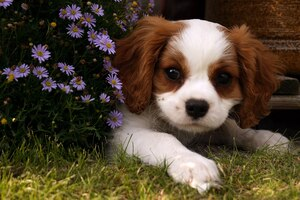

In [ ]:
# Image is Cute_dog.jpg from Wikimedia
fn = Path('samples/puppy.jpg')
display.Image(filename=fn, width=200)

In [ ]:
img = fn.read_bytes()

Claude expects an image message to have the following structure

```js
{
    'role': 'user', 
    'content': [
        {'type':'text', 'text':'What is in the image?'},
        {
            'type':'image', 
            'source': {
                'type':'base64', 'media_type':'media_type', 'data': 'data'
            }
        }
    ]
}
```
`msglm` automatically detects if a message is an image, encodes it, and generates the data structure above.
All we need to do is a create a list containing our image and a query and then pass it to `mk_msg`.

Let's try it out...

In [ ]:
q = "In brief, what color flowers are in this image?"
msg = mk_msg([img, q])

In [ ]:
c([msg])

The flowers in the image are purple/lavender in color. They appear to be small daisy-like flowers or asters blooming next to where the adorable Cavalier King Charles Spaniel puppy is resting on the grass. The purple flowers create a nice contrast with the puppy's white and reddish-brown fur.

<details>

- id: `msg_01SD3FDQbuJ4x98uNv62K2Xp`
- content: `[{'citations': None, 'text': "The flowers in the image are purple/lavender in color. They appear to be small daisy-like flowers or asters blooming next to where the adorable Cavalier King Charles Spaniel puppy is resting on the grass. The purple flowers create a nice contrast with the puppy's white and reddish-brown fur.", 'type': 'text'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 110, 'output_tokens': 75, 'server_tool_use': None}`

</details>

You don't need to call `mk_msg` on each individual message before passing them to the `Chat` class. Instead you can pass your messages in a list and the `Chat` class will automatically call `mk_msgs` in the background. 

```python
c(["How are you?", r])
```

For messages that contain multiple content types (like an image with a question), you'll need to enclose the message contents in a list as shown below:

```python
c(["How are you?", r, [img, q]])
```

In [ ]:
c = Chat(model)
c([img, q])

The flowers in the image are purple/lavender in color. They appear to be small daisy-like flowers blooming next to where the adorable Cavalier King Charles Spaniel puppy is resting on the grass. The purple flowers create a nice contrast with the puppy's white and reddish-brown fur.

<details>

- id: `msg_01VFVzc4JCVU1ZYxCiY5PBqb`
- content: `[{'citations': None, 'text': "The flowers in the image are purple/lavender in color. They appear to be small daisy-like flowers blooming next to where the adorable Cavalier King Charles Spaniel puppy is resting on the grass. The purple flowers create a nice contrast with the puppy's white and reddish-brown fur.", 'type': 'text'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 110, 'output_tokens': 72, 'server_tool_use': None}`

</details>

In [ ]:
def contents(r):
    "Helper to get the contents from Claude response `r`."
    blk = find_block(r)
    if not blk and r.content: blk = r.content[0]
    if hasattr(blk,'text'): return blk.text.strip()
    elif hasattr(blk,'content'): return blk.content.strip()
    elif hasattr(blk,'source'): return f'*Media Type - {blk.type}*'
    return str(blk)

In [ ]:
contents(c.h[0])

'*Media Type - image*'

In [ ]:
c

The flowers in the image are purple/lavender in color. They appear to be small daisy-like flowers blooming next to where the adorable Cavalier King Charles Spaniel puppy is resting on the grass. The purple flowers create a nice contrast with the puppy's white and reddish-brown fur.

<details>
<summary>History</summary>

**user**: *Media Type - image*

**assistant**: The flowers in the image are purple/lavender in color. They appear to be small daisy-like flowers blooming next to where the adorable Cavalier King Charles Spaniel puppy is resting on the grass. The purple flowers create a nice contrast with the puppy's white and reddish-brown fur.
</details>

| Metric | Count | Cost (USD) |
|--------|------:|-----:|
| Input tokens | 110 | 0.000330 |
| Output tokens | 72 | 0.001080 |
| Cache tokens | 0 | 0.000000 |
| Server tool use | 0 | 0.000000 |
| **Total** | **182** | **$0.001410** |

:::{.callout-note}

Unfortunately, not all Claude models support images 😞. This [table](https://docs.anthropic.com/en/docs/about-claude/models#model-comparison-table) summarizes the capabilities of each Claude model and the different modalities they support.

:::

## Caching

Claude supports context caching by adding a `cache_control` header to the message content.

```js
{
    "role": "user",
    "content": [
        {
            "type": "text", 
            "text": "Please cache my message", 
            "cache_control": {"type": "ephemeral"}
        }
    ]
}
```

To cache a message, we simply set `cache=True` when calling `mk_msg`.

In [ ]:
mk_msg(['hi', 'there'], cache=True)

```json
{ 'content': [ {'text': 'hi', 'type': 'text'},
               { 'cache_control': {'type': 'ephemeral'},
                 'text': 'there',
                 'type': 'text'}],
  'role': 'user'}
```

Claude also now supports smart cache look-ups, so it's very simple to keep an entire conversation in cache by constantly telling it to update the cache with the latest message. To do this, we just need to set `cache=True` when creating a `Chat`.

In [ ]:
chat = Chat(model, sp=sp, cache=True)

Caching has a minimum token limit of 1024 tokens for Sonnet and Opus, and 2048 for Haiku. If your conversation is below this limit, it will not be cached.

In [ ]:
chat("Hi, I'm Jeremy.")

Hello Jeremy! It's nice to meet you. How are you doing today? Is there something I can help you with or would you like to chat?

<details>

- id: `msg_01NRp9ys88wxbuTysaZnausb`
- content: `[{'citations': None, 'text': "Hello Jeremy! It's nice to meet you. How are you doing today? Is there something I can help you with or would you like to chat?", 'type': 'text'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 20, 'output_tokens': 34, 'server_tool_use': None}`

</details>

Note the usage: no cache is created, nor used. Now, let's send a long enough message to trigger caching.

In [ ]:
chat("""Lorem ipsum dolor sit amet""" * 150)

I notice you've sent a large amount of "Lorem ipsum" text, which is commonly used as placeholder or filler text in design and publishing. 

Is there something specific you'd like to discuss or a question you have? I'm here to help with meaningful conversation or information if you need it. If you're testing something or just curious about how I respond, feel free to let me know what you're looking for.

<details>

- id: `msg_01H6ovSz8T1V2rj4iynbeKvH`
- content: `[{'citations': None, 'text': 'I notice you\'ve sent a large amount of "Lorem ipsum" text, which is commonly used as placeholder or filler text in design and publishing. \n\nIs there something specific you\'d like to discuss or a question you have? I\'m here to help with meaningful conversation or information if you need it. If you\'re testing something or just curious about how I respond, feel free to let me know what you\'re looking for.', 'type': 'text'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 1101, 'cache_read_input_tokens': 0, 'input_tokens': 4, 'output_tokens': 90, 'server_tool_use': None}`

</details>

The context is now long enough for cache to be used. All the conversation history has now been written to the temporary cache. Any subsequent message will read from it rather than re-processing the entire conversation history.

In [ ]:
chat("Oh thank you! Sorry, my lorem ipsum generator got out of control!")

No problem at all! Those lorem ipsum generators can certainly get enthusiastic sometimes. It happens to the best of us! Is there something I can actually help you with today?

<details>

- id: `msg_01KsvSSaJjpuRst2BejF2LbT`
- content: `[{'citations': None, 'text': 'No problem at all! Those lorem ipsum generators can certainly get enthusiastic sometimes. It happens to the best of us! Is there something I can actually help you with today?', 'type': 'text'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 108, 'cache_read_input_tokens': 1101, 'input_tokens': 4, 'output_tokens': 38, 'server_tool_use': None}`

</details>

## Extended Thinking

Claude 3.7 Sonnet has enhanced reasoning capabilities for complex tasks. See [docs](https://docs.anthropic.com/en/docs/build-with-claude/extended-thinking) for more info.

We can enable extended thinking by passing a `thinking` param with the following structure.

```js
thinking={
    "type": "enabled",
    "budget_tokens": 16000
}
```

When extended thinking is enabled a thinking block is included in the response as shown below.

```js
{
  "content": [
    {
      "type": "thinking",
      "thinking": "To approach this, let's think about...",
      "signature": "Imtakcjsu38219c0.eyJoYXNoIjoiYWJjM0NTY3fQ...."
    },
    {
      "type": "text",
      "text": "Yes, there are infinitely many prime numbers such that..."
    }
  ]
}
```

Let's add a `maxthinktok` param to the `Client` and `Chat` call methods. When this value is not 0, we'll pass a thinking param to Claude `{"type":"enabled", "budget_tokens":maxthinktok}`.

*Note: When thinking is [enabled](https://docs.anthropic.com/en/docs/build-with-claude/extended-thinking#important-considerations-when-using-extended-thinking) `prefill` must be empty and the `temp` must be 1.*

In [ ]:
#| export
def think_md(txt, thk):
    return f"""
{txt}

<details>
<summary>Thinking</summary>
{thk}
</details>
"""

In [ ]:
def contents(r):
    "Helper to get the contents from Claude response `r`."
    blk = find_block(r)
    tk_blk = find_block(r, blk_type=ThinkingBlock)
    if tk_blk: return think_md(blk.text.strip(), tk_blk.thinking.strip())
    if not blk and r.content: blk = r.content[0]
    if hasattr(blk,'text'): return blk.text.strip()
    elif hasattr(blk,'content'): return blk.content.strip()
    elif hasattr(blk,'source'): return f'*Media Type - {blk.type}*'
    return str(blk)

Let's call the model without extended thinking enabled. 

In [ ]:
tk_model = first(has_extended_thinking_models)

In [ ]:
chat = Chat(tk_model)

In [ ]:
chat("Write a sentence about Python!")

Python is a versatile programming language known for its readable syntax and wide application in fields ranging from web development to data science and artificial intelligence.

<details>

- id: `msg_01S9DaYTNoo31yNh6fHZcQZc`
- content: `[{'citations': None, 'text': 'Python is a versatile programming language known for its readable syntax and wide application in fields ranging from web development to data science and artificial intelligence.', 'type': 'text'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 13, 'output_tokens': 31, 'server_tool_use': None}`

</details>

Now, let's call the model with extended thinking enabled.

In [ ]:
chat("Write a sentence about Python!", maxthinktok=1024)


Python is a beginner-friendly, high-level programming language with an extensive ecosystem of libraries that has become one of the most popular tools for both quick scripts and enterprise-level applications.

<details>
<summary>Thinking</summary>
The person is asking me to write a sentence about Python again. I should provide a different sentence than before to offer variety. Let me think of another aspect of Python to highlight, such as its community, ease of learning, libraries, or another key feature that makes Python popular.
</details>


<details>

- id: `msg_01JiyHw3dYuqgbdHqi3jNvTd`
- content: `[{'signature': 'ErUBCkYIAxgCIkDGyn1SbTWjPjZr8XN8EIk5Y7YWiDvWZT2A4r+vxn8pzP6hNNkf2MmWpOqe5a42Ap8tlgvNDLg/98+wbkAbdLVWEgx/k1Ann3OFL7gBruwaDEyTKpSxI5/ZwVXm2CIwtZtisIvmybu3gAfvnhosRn3aChBZjl+RIBCAEs+i5BKE142qhTJM2d0XQk+JnBhWKh0/GloGOLUPWVsV/HpAFB61np8MTxhGhCCf04mhDRgC', 'thinking': 'The person is asking me to write a sentence about Python again. I should provide a different sentence than before to offer variety. Let me think of another aspect of Python to highlight, such as its community, ease of learning, libraries, or another key feature that makes Python popular.', 'type': 'thinking'}, {'citations': None, 'text': 'Python is a beginner-friendly, high-level programming language with an extensive ecosystem of libraries that has become one of the most popular tools for both quick scripts and enterprise-level applications.', 'type': 'text'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 81, 'output_tokens': 106, 'server_tool_use': None}`

</details>

## Server Tools and Web Search

The `str_replace` special tool type is a client side tool, i.e., one where we provide the implementation. However, Anthropic also supports server side tools. The current one available is their search tool, which you can find the documentation for [here](https://docs.anthropic.com/en/docs/build-with-claude/tool-use/web-search-tool). When provided as a tool to claude, claude can decide to search the web in order to answer or solve the task at hand.

In [ ]:
#| export
def search_conf(max_uses:int=None, allowed_domains:list=None, blocked_domains:list=None, user_location:dict=None):
    'Little helper to create a search tool config'
    conf = {'type': 'web_search_20250305', 'name': 'web_search'}
    if max_uses: conf['max_uses'] = max_uses
    if allowed_domains: conf['allowed_domains'] = allowed_domains
    if blocked_domains: conf['blocked_domains'] = blocked_domains
    if user_location: conf['user_location'] = user_location
    return conf

Similar to client side tools, you provide to the `tools` argument in the anthropic api a non-schema dictionary with the tool's name, type, and any additional metadata specific to that tool. Here's a function to make that process easier for the web search tool.

In [ ]:
search_conf()

{'type': 'web_search_20250305', 'name': 'web_search'}

The web search tool returns a list of `TextBlock`s comprised of response text from the model, `ServerToolUseBlock` and server tool results block such as `WebSearchToolResultBlock`. Some of these `TextBlock`s will contain citations with references to the results of the web search tool. Here is what all this looks like:

```js
{
  "content": [
    {
      "type": "text",
      "text": "I'll check the current weather in...",
    },
    {
      "type": "server_tool_use",
      "name": "web_search",
      "input": {"query": "San Diego weather forecast today May 12 2025"},
      "id":"srvtoolu_014t7fS449voTHRCVzi5jQGC"
    },
    {
      "type": "web_search_tool_result",
      "tool_use_id": "srvtoolu_014t7fS449voTHRCVzi5jQGC",
      "content": [
        "type": "web_search_result",
        "title": "Heat Advisory issued May 9...",
        "url": "https://kesq.com/weather/...",
        "page_age": "3 days ago",
        "encrypted_content": "ErgECioIAxgCIiQ4ODk4YTFkY...",
        ...
      ]
    }
    {
      "type": "text",
      "citations": [
        {
            "cited_text": 'The average temperature during this month...',
            "title": "Weather San Diego in May 2025:...",
            "url": "https://en.climate-data.org/...",
            "encrypted_index": "EpMBCioIAxgCIiQ4ODk4YTF..."
        }
      ],
      "text": "The average temperature in San Diego during May is..."
    },
    ...
  ]
}
```

 Let's update our `contents` function to handle these cases. For handling citations, we will use the excellent reference syntax in markdown to make clickable citation links.

In [ ]:
#| export
def find_blocks(r, blk_type=TextBlock, type='text'):
    "Helper to find all blocks of type `blk_type` in response `r`."
    if isinstance(r, dict): f = lambda b: b.get('type') == 'text'
    else: f = lambda b: isinstance(b, TextBlock)
    return [b for b in getattr(r, "content", []) if f(b)]

In [ ]:
#| export
def fmt_txt(txt_blks):
    "Helper to get the contents from a list of `TextBlock`s, with citations."
    text_sections, citations = [], []
    for blk in txt_blks:
        if isinstance(blk, dict): blk = AttrDict(blk)
        section = blk.text
        if getattr(blk, 'citations', None):
            markers = []
            for cit in blk.citations:
                citations.append(cit)
                markers.append(f"[^{len(citations)}]") # maintain global citation order
            section = f"{section} " + " ".join(markers)
        text_sections.append(section)
    body = "".join(text_sections)
    if citations:
        refs = "\n\n".join(f"[^{i+1}]: {c.url}\n\t\"{c.cited_text}\"" for i, c in enumerate(citations))
        body = f"{body}\n\n{refs}" if body else refs
    return body

In [ ]:
#| export
def contents(r):
    "Helper to get the contents from Claude response `r`."
    blks = find_blocks(r, blk_type=TextBlock)
    tk_blk = find_block(r, blk_type=ThinkingBlock)
    content = None
    if blks: content = fmt_txt(blks) # text or text with citations
    if tk_blk: return think_md(content, tk_blk.thinking.strip()) # text with thinking
    if not content:
        blk = find_block(r)
        if not blk and getattr(r, "content", None): blk = r.content[0]
        if hasattr(blk, "text"): content = blk.text.strip()
        elif hasattr(blk, "content"): content = blk.content.strip()
        elif hasattr(blk, "source"): content = f"*Media Type - {blk.type}*"
        else: content = str(blk)
    return content

In [ ]:
chat = Chat(model, sp='Be concise in your responses.', tools=[search_conf()], cache=True)
pr = 'What is the weather in San Diego?'
r = chat(pr)
r

I'll check the current weather in San Diego for you.

Based on the search results, here's the current weather in San Diego:

May Gray has returned to San Diego after a record hot weekend, with temperatures dropping dramatically. [^1] 

Today (May 13, 2025), temperatures will be significantly cooler than the weekend, with highs ranging from 60-66°F along the coast and 59-66°F inland. [^2] [^3]

The day is expected to have "May Gray" conditions with limited clearing into the afternoon and possibly some heavy mist, drizzle, or light showers, with the best chance of rain having been overnight into this morning. [^4]

The air quality in San Diego is generally acceptable for most individuals, though sensitive groups may experience minor to moderate symptoms from long-term exposure. [^5]

For those traveling to mountain or desert areas near San Diego, be aware that a Wind Advisory is in effect until 5am Wednesday, with west and southwesterly winds of 20 to 35mph and gusts of 40 to 65mph, which may cause blowing dust and dirt. [^6]

Looking ahead, sunny skies and warming temperatures are expected early next week. [^7]

[^1]: https://www.10news.com/weather/san-diegos-weather-forecast-for-may-12-2025-drastic-drop-in-temperatures
	"May Gray is back in the forecast after record heat this weekend, temperatures are expected to plummet up to 40 degrees by Tuesday!A cooling trend ramp..."

[^2]: https://www.10news.com/weather/san-diegos-weather-forecast-for-may-12-2025-drastic-drop-in-temperatures
	"By tomorrow, temperatures will be up to 40 degrees cooler than when the heat peaked on Saturday, with temperatures topping out 5 to nearly 20 degrees ..."

[^3]: https://www.10news.com/weather/san-diegos-weather-forecast-for-may-12-2025-drastic-drop-in-temperatures
	"Tuesday's Highs: Coast: 60-66° Inland: 59-66° Mountains: 48-60° Deserts: 77-80° · Follow ABC 10News Meteorologist Megan Parry on Facebook at Megan Par..."

[^4]: https://www.10news.com/weather/san-diegos-weather-forecast-for-may-12-2025-drastic-drop-in-temperatures
	"... Tuesday will bring a return of May Gray with limited clearing into the afternoon and anything from heavy mist, drizzle to a few light showers. The..."

[^5]: https://www.accuweather.com/en/us/san-diego/92101/weather-forecast/347628
	"The air quality is generally acceptable for most individuals. However, sensitive groups may experience minor to moderate symptoms from long-term expos..."

[^6]: https://www.10news.com/weather/san-diegos-weather-forecast-for-may-12-2025-drastic-drop-in-temperatures
	"Gusty winds will continue to target the mountains and deserts where a Wind Advisory is in effect until 5am Wednesday. Expect west and southwesterly wi..."

[^7]: https://www.10news.com/weather/san-diegos-weather-forecast-for-may-12-2025-drastic-drop-in-temperatures
	"Sunny skies and warming temperatures will be the trend early next week. "

<details>

- id: `msg_01ViZRYeJmq1LNPCPVeZraan`
- content: `[{'citations': None, 'text': "I'll check the current weather in San Diego for you.", 'type': 'text'}, {'id': 'srvtoolu_013GJBBVbHBH86m3ocWQBoW3', 'input': {'query': 'San Diego weather today May 13 2025'}, 'name': 'web_search', 'type': 'server_tool_use'}, {'content': [{'encrypted_content': 'EoUQCioIAxgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDFUhQOr66X5awQrELxoM5fuN/kiNCiPCaGsvIjCrFzeDaIPk+dbacLHhiR1SMjm1jr5au9rO8d7L3mC6kjB8nWgZxvqVuipeybwnXrUqiA9WShX7UYFl3p+Mq0u5DctVNFbnpDJXglc/ujWW0V2ufGIldSUQUyKGfSdmtjYAO301DW7zOTccQ02QCePvu/WXIBsNHJB2SIeEK88SFlfrzMi5T/iGwyJeFl4dLshxFLW3BbpRtLfb8V9wYnp5xa/o87y4MBL+Trxc7DQLPBZeoUN5YMhRnUzZJjwJV3jlHiIvuFBAiSJ9JUnDAXIyMlB1/AankFoGYTSC+BnNpBbLpy4dOyDLv7DyoOk+p6YT3pLE2+FHBHBcZB27YEEyg+a6ChMlcI22YteoJBEprIsSZsGs+l2wC8tM4eHoeyEgS5ok7/XWeg05nAZR28JM6Xom4Dg0bvYLdCIuQr4nWw8fXGurkUSGU9/nSHJuCYGXlYzM+pUbY0g6j8nau2Jd1v90oPPxph34FECAnc/rsdR38SaFGuMhkyM7BdvwoTwdX9sXqV0F3WmzlRQEyVnefUrHQKODs4QnTmQ0USywSL1423UtELDfZmxbisrW7rsAES6Dp2hXBb+dUeh5ki0RAUqEoootS4tml7DbBRfZdSq0oPm9Cr9pu7A1grpARzBAEzNKlRp9+OxDHqSxXXZe7lrIHGSDJRcwLwlgKZ1EWqOqS4X7/shV9DfaNydWQb0GDKBn+sFcAgAUm85edYnt7eC1zudqor/yokeRoIJYdZBr/MBMVe78Yttd0zPaVrtFiApCSb6jYwYdVR/fxqEHBJg/VrhGePGLEPY28YvZA5Cpt2gjNp3pGio2txFG7376TB2Ok7xlqz6aO35kTHKy/xWHze+pyFvYvF+HGqAnPW1uYmedxaz+tF5kbMIM4uCtAGkFi2CC2Psu0PkFj4a5WHoq1FRIPWySiyMFj/RvDb/v7s2udlboWSft+AUYyqFE0K0H1c6Q68PSIBlbaV2seEuSSHDStj1EPSc9bh2TvX6imfzJ9GDmpEd/Afil1KONrLtTYEm3Iq2ziAuzBiL+s2JGpwEwzV5k3Odj2pYnnP3WiCX1Pq8q7Iqa8D8bRG+XzcmlU2fG2aty5cKG8gNH02E8FDq016sMGEfFY79JJyEfqzmfsFQavbLekCwLbGfnUXgltf4ylO+j1zqGsB+6FQKivgbG7drDQyD7vt4i/+Nljmv+l6uwSC29okwI0Suq3+qzwlckR0oftgdvftPjonXBWx/qIzpl1pEI5zgBoNkhRHN44/7kuWb/MND8kJNjrMEelcIbmwr6hGgXfou+bX5ZkQSYA+AI31010n1gy27unzF/5TFl4tmNEYVIMhFPfogYkxmDQSOV+xOgqYvaeNtBc9scuM87OF58ukWBcvJh32e6d/VOIHPhXUKiz/5lQx9B1N1mcTobd6jxJyqzjFzJMMc+gVdUQfDxdr1rj8S1XBNHTdAwKcbbNrSdOkyqkthuz4kcYpHQMJKYD8r7+UIhg6vTcdg/4iAluBafvIT6dnt8QVREZCJVHgWHg7Drc/KykcWAuEWz+BtWhSLy+M2y8HYoTl9KSJKoyQ/rzm0+opGXqG4o0xFh//r3k99alHSjZMkChsNBIUH/gA/Y8JOUXojmreYa1viiWTcCAj4Rbk2tqWXy+4T70sS48CEmVnanyLuNxZtqt3utJ9/rDOtMsPJqxpYMIHZ/+ytA5Z60tffd6mY9wMMg7uaLyA/0vofeVARqkOmcy0l8cc14+S7jq3KzW3fFq8PAsRhb/7eS3lW/MxiSfg+5GM/yuSLJSrEdKfGj6HD9+ehwYfjLQD2sjG1U/RkUEd9Jjx8QXJhPCNSexvggSwsCyYA2u+tlaRnvZqoPx0V6kzC88c5dvPQxPC1jG3yL/wcxXQefiTWGUT78LpY3/ntEo8W466b+6+U+3tyVbu4J8YnSvfiyOZjgbbANORle4G4BNkZp9soqlfZwT2EGo9gY0L68LPazN6eTd4byBgBPpUdPvZxGPW6iQA8kQsgqxBuPtGHPew1/+nscNBFNQQGcFtkYsZ8Ibp7bLTOgtDVeMW2ksQ97ZOuGPJ2nw9YT3Xd3uAL8E/A7v/o7s/PBDlGY376NrYva+hxTnKpSvyqdXf45Go5uGCdfuM7a7DRpKnHZQF9araNdj/KSU/CQ/rr1brCQgB9sanLzAN3FQpPuXJNS+qN167GlRnYQI+wCaP5XEamFDaO+oXyN6Rg8FdtgSyoSZ6K4XF0lAyYRWJYpZIV48LU/d4/+h62VFmoWbfIEWzyCso9CBytegF9ze/zu3Vuc+TBz2s45rvg0dl1AV+eBIcWZernHMMNLxJNAeJbeds5PL6Zj8QuRd7fBt/0KCnNpL9lalHubxVk5MCjgiEYpyAT2fo2bssUX7jvODQ12t3afImVSF2i2kAYE9Yh85xr2rTCiROarfDlInI6UFd/CIUbgLwJZm3/As/JM9Qer4N65RitEqAtD1+lPsIE5UqDs4x92UKznvHHT+BKddtScU5tw4AlsmRZkTlrIlPFofnxMgYCARjMQZ2IQUi/IcFs48x928YV/BGVSXZZEBwGl2TNyGlDGmBBgQGIgow+MBhsc8EJlN+0D0lXwvxUTI6AogJ8rvf0JNOIxWL/34hgD', 'page_age': None, 'title': 'San Diego, CA Monthly Weather | AccuWeather', 'type': 'web_search_result', 'url': 'https://www.accuweather.com/en/us/san-diego/92101/may-weather/347628'}, {'encrypted_content': 'EqADCioIAxgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDFnNt5Y/WQ1CEP4WShoMAIpp8Jk//kn5hnnIIjCO5lKVoEzQheVP0vcPztH+BiasL1ycEFYs4zPMM+TVImLh+7BMQd31ePZGWANFS7gqowJ6xpjUIiIlk5i9P88yhXvdaOJbPbAlJ1Ye3l1P+2zti7L+ZymXvg7AEz57vDadegRZwCNnAcfYoCpnEL2UHPPblHpwoyRQFZR0sGEdDHTrOkghu3LlbmK0JyDB+ITb097OY1g69c6XIgv+UArKABns2CmH8PNSKJ1OkMHU17skCaIys6jVlxOcO8QaGIkoCEIrEyQBc7KCAaO/Wew0+C2lns67coMiAcPrOm9ys2LxVteEUnszKoMB9IFaMRKrOsANtEdR5eqfh7xST+hrHhlN4ZXJPX5Whc0NiWsClAdOCVUiLUycqRUmUR1SRQzAnyulKsLKfAFUZYLoFVquWiOAEbFM2uvP4uU3g4WVkZyTgq04gyrNvJYVmrNfMt72DG21/sYYAw==', 'page_age': None, 'title': 'San Diego weather in May 2025 | San Diego 14 day weather', 'type': 'web_search_result', 'url': 'https://www.weather25.com/north-america/usa/california/san-diego?page=month&month=May'}, {'encrypted_content': 'EvADCioIAxgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDEUg7T+dDnLBQ9D1JRoMngid1tYnOnNlMzgLIjDhtRLoxIwXzVlTQSgop2f3Izpsi4fYmjbo8ic4T9IkPZoVsrqYDufsBn+7CUhXvdkq8wIRDgFJG1dJ0Zt8O/ydKfXzHAryxbopAMM6r5ipydRY3iwBys8AD0AtI0UFjPi/KKyhIZEphIJuQhMIeighlc+f1YuNVc6kRjJIxGvzawMeaskfqo3edYBFyjz7HUTN1JxGYSSFQuT7VVefF2k0smcHg+Se1a0NjyKY1qemvgaEtBxhZ31cEn/uPz2oe0qoT8Jr6Cm+1RJkW8haert29P9gpIsljmIyfnzr1WeYofYnESPGjLYQy6FVoyWzVhef9UuaUKydDAx7Qhwv/Mh/QVxDh8LbK25oWdv5uwC7NefejFVMS8619eEM4HtEe5NwECwPU4lILRvQBZGU3IfyCMZO/MF1fAPN9b7ZTyOaOypV0k+oMWwfDyIKIN8dzjF9rMzN1XsrkGQ3RAWIpbYjyvEXb/BcS9BVx97GAavDMYXhE0m3s9du29HVvacduknFNwS+GF5irdJYw/r0l7PsFsTIpOBhOb/JSUvuUBp661wZzG5SoBgD', 'page_age': None, 'title': 'Weather in San Diego in May 2025 (California) - detailed Weather Forecast for a month', 'type': 'web_search_result', 'url': 'https://world-weather.info/forecast/usa/san_diego/may-2025/'}, {'encrypted_content': 'EsQYCioIAxgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDNIyquvplW3wehyVRBoMvzbwcp9Q84Cf3AW6IjCy83VuapSMgNimREnQ0SyNH4w7yTqZOSU8Jq/LvE4dg8OP1GbCR9NQlew/FXdc4QAqxxdg+XI4M3u1D2yPPnd4ZdFTXWG8+K3kvKYerMoPWqkHVDMgNjFVANcrXrQnx029Czorkx2ZI3UPoqBeq8oP6tRT7lZyGt04/7OmAho2CJ/VRlV+SR53cVVB4euHefuOFAsRZF+X1+mhMJtZ2olDwoViEk2w/1mjZnYw5C2TDrGSh6hnSPx83kOIfOJJA4h+o9aRZ8JieAQ/FdxFcwuCYqotQkwAGC8WpraE0yKgiMT+vHFotUKPUmFlYPIPLpWaRXeIJlttoIlOqsA+/RAEKYGTz9KeNS8xzlWkKhWOMrURczwraBfuFoW1ek+pnEbqB6SeAcc95/oZF0rphuutmndZDl/85563QjFp9hYIvW0HEwVXfzEsVR9QoDjnX5JiONlwFlvcuZEyBpOYe0yVh7SROr76Is+dsm+m2hZiQ9L1fGZCy4/uqBot0j9XQWy4zjVijsES1NTjScMgYQBpa6SGEYfmElVsAhKSrYVwoSgh10cmgr6rdXSjp8F7PItdud3VwP9zMTl3LXUmpBH/o9aRyWsTWRheJidvSjER37wOIWnuvbVqpnVKoJ4G65u5pbFpZxX2z9ZUDqDWYNSR+0lJnwi+pDRz2hsm8/zWj8mHmltiQ1KewZQCk/w4c9bMqLGxJUiesWxTajo8Ai0/m5R6XYls6n9df9VUVC/4G3g4Y9fMNCN42C0rSUWTg7tcAzl+8FyD24QAxpyC1rICjKcaII6HWYMI1QcEnM+gw/bbr3qBGQpEVp+ov01EAJ4LIlo6NLQzwfxT/zAfKRdynBZGKPINOKeNpedrnTFyCPGF/uG8/oe2GfAjxgnOtH57/A83vIGpDU3kTQ0j7+bAZNHtBPOZkyoGCOcv4LLh3K647bG/hOm/eaO0B2BPOOuTa0YJbY4KeH5jKd/72SBXXegTdySpPJoOrStIYrGhkyJ1L1MPnM+Jo4nikV/Zmo6AJA8BHrIY1CMklUftjFIeUtxoV/LupiQBYn+2fyjOJ55sksQ4W0jaNtT3+n9Wx49jGVZXdb2H9x8RfUI2vUvc4d0fkkCCoQZdfSh05VpPlJFyH/tUoU30+pxUyOBcKBrGMa7AkoL7puI3taKtdaF2XSeh55fdm6kZdvnEprKWSgj8YRLQjVMFgUwKf+DcqhdBprBTa51o3bhda/RWq9/lR21tvz/BhyCXnYyrFgw73eONGZep85dQSuDpzAjGYxMXutuHIa3S2n9cEK7kv5m5cId4ebSMfXvZIOqQkF5dxKRMApP718tt3YsRKoZaULMSPpCnkKc9VyddlgBXSUAP/7doKcD37MmIFYekS+o0tSUD0KUAx2g0k0q+bAfyTM39tzJEymQhFRl4qjCiwvBrxlVFqWaGCp0PzrVQaTwLDLcYzvWiUqtjMF1HpCdfuKlM1VZkhvBB4hPhSgxH51HuABX2AE95Nq5/qnoUUdEkMo7fc9oQofY7PIhDUe16athSKAXUvXSAIWmgOzxx3WHza85zg37YsJ43S49A9kHK3QRojNri2FR/cVnbrS3Ds0HSPTHP6Hi0sUzKRDiOR9Umzy03RuDncLRURERbVwxJ5yVnBTtdPM4IcORgOmKVbGS0JTf/1q6TTE8+lbMGkyoVSnTsIVvlEd+CDKIlyMmzxqFv8G4+5B1MbQgFZzJfcV3kEnzKe1XO4/gx34QufuUGymD29B8z3jSlJq43q7MXedDkUXlyq69Hliw8UtyW0/Jdtmc0pRq2JLMFDC1CLjC86iax/xYykRMlKkLzNLj5Yo9TKC5hZovxJb+U+QECspbwWCJRh4ivmfktkiXLq0gT/c3FgoJHewbj7qTS/igI6KpkKE30u/Dg3t4abW3mCqBzcjqwecDOMwOMrRSbyWJRBxDy7pcA4WZ0sO5kVPAt3C1HZNi4h6G1vNtxPSt1vsasPXVqYdNzYRMq0l3onnhvbmwvPc+QownPk1vqxUVNO1kzFXuIw2uf00mszQqmN/Mm3csvKg16PL6kaMmmo0GgqDH+/udDJUFfWdnKdx/t/+DqrX6Q+urmaxCR9w6jcsx6xIB0H2Fie272iE3YkevkwtIAQL6CIMfatLWvkEwY3crN1p0X32cf+MYo0GXR1kdSqfQ4eZX3+0TxbnuIom2rBmMRt8FxddtEKU2RQqPPmm7BYHPqkVEHOJF0A649z/O+Asd95d2G8nju+JRETQKYPYKHWDu+GJM3gLeJtB8bK3/0/vT280wg+gi73XSZX2WXVShDRWfq8PNKBWg1E3tbtvl00289LW+kWaHsRnp2I7Trc8fCWNDAAGlP3k+TaQ0QnezsvuQPQhQ/OyIFtaDqbuEk4tUD5dOqWehOpiIUqbmmYwGXgloxCH2cWSibnabnXiX+/dIF2Lo3c960ZukKEoEUQwcvLEhMeCl0aEsrBOJZ/2Ey+J8APbh0v4IyU4v3pEWIoAxJa9yoJi+Sm+WpSaKOnEJ+/Hr9gTu5ytq+DwjfYjcRMOxPUhxP7z95F9UZRfysGwJp2HElDU9FGylMSFQuA5l/uWyikR4sE97yLov49NKOmuPyVTn45jVndg1/LSFvGilRrVWaUDiE7KDqhI90kBbCoobnPkGUz5xNDaYw2lhsMhpo/vBuv6c/5BAtU7qei0nIRGG5SAdwqjh42I26lZas69h9Wi3Vk9+73fXy+CP4k/dg7NUDA+Uzc0KQ82l26rzOeyzqFxntsHcfQfo8lnDCvnFk/acnQ8S5eEOAPJT6sm8hIGigdBiF4P9B9tF1a/NjmNqfwdZZo7FHY2S/Vm9DMge9xuNqq+gfPt8X1yaQZjJiQox5JKJVHjQDfsxvI+ZCUeMXXbyQwgLbcOe+Jf0rHOxEuOexiGoRTIkTEdCiTA0e7W6WVVRQ1TL8n2pP1CmMNmZU5eaJNz1enNhx91ktEG9LXy+wEY8g7dt+y4bWQoNT5BOH0vfQIKP/kRSewb3Zx2rulIGsBsPj1cW0NAbosU0UlyS6bPKWVUCEy6t6GF7w3K1dxuCrtXHOfevQtU+qt9et7F0ubUV+s1n69iqsL6TR34gQLgfettGpft+KFrXeF5QqC+3HsIPXzVRCJZ+myNLU0aE+HhJ2DUbFUU0UoT5Fjwu8VOa8fZesZb5G9TR4BmwyQhlT/MVM95OE9jZ0/e6qUhMM7Hrc+Q92019zhctw8u9LiRdk/ilv90IimJJG3rCpGkoeJe3mkWPecxfvxjhgkruYwhW4l8haywBWG8+ybJnMpCBkJHqJx9zP9kDo6PyEyvVJ83uSE+34ByvO9h7TA1ui1TLuJGqbAEh60es1P/BYwKJWnyk1nElivYRPusy+9TpZ0DGmozbfwfA9oJniRxJ5X/gVJkmyYtc2UQpVRP/csdPiHTkCzsofZfsw5boNdEl3a1znpGZOV1Z58RBhGIxc0i9QDS5cnQ6rVNAnEM59OwalppY2KS6hB5bqDLMljnzxgp6UEIYfqeVBMhryZOzn0+ejJnLsx+6hw/NcAw7x98nBEcEHeUytiiTlWrZSOqeL40RQ5GV5wWaoe2CCJ0CZwsVlYudCyV92RCjOuBKcJekVFtgpLYeWa0C5VnFo6GxOWcuUbYxsaknl6DllJ2RkkbpPVmjoynuoEZiEIOldffKEtPZnX07T2fchc/Dt+atptRjJJSRc0H0wf6xP5DsJPXNlQ9U35Eqt+BLin6amBjXDKGKqt/CXmQNI9veEGjd6THQa8N18bHF37D8gP3L7bOHUY9ex4MNfieWLkuA2EM8s79xIwnnD6Jyt4maClcS3IIikPQ6JUwAdN8Vb2/FXhV+qGCEv0x0atkvZDEWWTlAdgAyXTVjtgzb+ZKfwBmNUE0gS7tlhl/4NRlN2Ofbq1IGlCokqJgz/eJIRsEBJpcr/CfdMMW0vxebZkQ1JWCqmlSPydk7k0yWTV/IK3AA8k5hzSet/JQqzP383+LWshkqjDVQowmAppyXfwUT13YHMIiBxtlhAJDj/H1zM08rU8ibH6LEa7h60NsLszrET16sozsJwAuf3C/jNjXEYAw==', 'page_age': None, 'title': 'Weather San Diego in May 2025: Temperature & Climate', 'type': 'web_search_result', 'url': 'https://en.climate-data.org/north-america/united-states-of-america/california/san-diego-714969/t/may-5/'}, {'encrypted_content': 'EqsDCioIAxgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDIOWcXpS5jZbmXMNyBoMnhOYKisXOS5P1x32IjDd0j8JEcJoEx3+HBBiaKpoS4r/d0WV+tjZM0Mfi9l9Q8eopqWrG5dqAOMv9donaRgqrgJxOaKpMI7EtU38zKZxl+MOegtQWb6OjGl2p8M5gtNhIjhUgSWHWGwC6q6oKWhPSq0IfCus7ZTiahic1pRBnviKSF2wxRP1x8Zws8/U/pyb01V8wRXTJIWRktYEHkmSFuV1C5uk0MLKPxqB6OXw+JImWbhWV21FBvzznG0obwl4DgYNRLy12Yevg1mrUPT1Io+pVsbhIaclDd10ImqF0u0NmLmwIO3v94UocETiHiyEU8+PAq60INjudde0q5LP0ug6R9o+r/2B2uPAxDeGVpReULlfL+pQ5M0CT2IK3day7igUjCLXGiv7TWG+Hr94NQaD3JmMNDc3Umwpfdl/DzcUQP27jGM+tROxe0JubhYhr25f/hpqDap8l69KmztiIERRtjX267tQuTvhbYBb4hgD', 'page_age': None, 'title': '60-Day Extended Weather Forecast for San Diego, CA | Almanac.com', 'type': 'web_search_result', 'url': 'https://www.almanac.com/weather/longrange/CA/San%20Diego'}, {'encrypted_content': 'EvoPCioIAxgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDNA29W5eMjiYVPioahoMQ9p6061HaN8opiDFIjDYCR8w7tg/q73DUWY/OQysPqdwD7VXFcuztQQXnGmEEn45HnSPwT6LAUcVXmZ93+Qq/Q5dQZRGndf7HIQSaHrGIG3eNyQiRMEnCD+DK2GmyWf86HHXUdXmy1Xuxf5ob9zD8/cgVvT+ASpupu8oX7qWdSyXdkbgbxIAhjeTGLcKJ4Wx8ABueZpVmW6665oadbT6ONzhUq+SoPo9jEVB+ZS88B/NX0f0ZEK9qFxej0wRbHx7bJGNS/4o5eBTlleNT04uiAl0al76dgNxlFx8zRb+CjRmKpJ9gdmZd5bws2bgJyLtR3LwWKwYZw2OW7Bl1T/unp8+GxKSx4UwmeXz4fxDWbe5O9UfZgh+9pPu29OWzmgHFrQCjzzIzL9zF0NrjG4PDdOBtrbTXQ/+zopHDC9ZsJGTkrmrLod2bTIWBowfkk3+5I4FsNAATBokgO48Y9wywW+DedljCdUP8CheMfx9NfWdbt+0wj7sglzFAJiitHKgHn7Eq+602kQYZXWFFzLLhDLfPM1yCmLA4YAHzhM2kLImYX2f+516E9ky+vz82xL3AH8rj8QIo5aXFyydTOHeptIFwJt+bcN/gcqAKqPa1e+sjCMyjwvYH7luq84r+T8OQ3qd35+L4ctLM2o/bH59FFWMG7I1Sk2D3xaOP0SZAnW8KRtTSfC5LpzcZSYN1E1R9VZdDyZLyXSvu6Yfl3wRrVSEvVH/zEZ6Ca15jTIt8SjuZiIeMomK0zb2LwXQq3X3mkWzUsYHH79zWDEjfcEGAEqmKReEPVAReQKV02wnBGJ/dFS89SgMjDSx2tHLR3qqsUB98tYnVJe7c9JKGNf80a2aeRIougp9KdryCoaBHAcWVfxwWmeVzJ/6ADvCtY2AwtPw0K5RL6sQ9ogKlRFujGGVUnp4zwec3UwEVCTCCPjft1B1oovKULkN8L6UVjAdiO7u5fLpLpf8r9vg9j7gDWd0wwXrnV0KBP+96Z8MJOKDFAkxwcdtNEmOh5JFmbLq67TsXWUIGdw0OTyg/rniE4oc3Qyms3xWE7xmAojSzhM1J8lMsc5EjSe5a8e3sZ47jvZnosBnV7glzf3KjI5j/R7zXXK595ho8dJZ1gcK2niIHdKsj2KkPXCcUmI8f1e26hklfuMmR1eNqjUDEnlQTIo5+kjYS5z8emdewkoUaRU+AqQOIOV754wpZ8L5h+z29dtYUsmIlRe87TNbuBxpnHTyXTqNMZ2LWBc/r1MQkOSLEkysYmA7YHRzs10XkwJp47+HHS005620EMUCPEYVOt91qMb7qn34nM2FIal+C7cK8t9WFtbLH7+sGUagdrR+yxbEYJ281oqnl4o+m//JYr/Bh8Vq/H13CpJtdZNh77mL/LzbDo04VdLaLr+AfqMcRRKVz4VTV2+qSvadeiJdz+kBLFWa/M6CAJpwJjZ32MQ1n2oqPbaZnbPmcKOO7buWStPHpTAqsdYlGWQ0CERsYnmitynp0P9PrEA1AFipFX0M8VIBVF94Go8dT02uIgZZjJ+2q0Nq5aBcs3klDXbwoNz9V/pCADl6s9POVy0I0alOBWKqiAep9BtojDYUAITAivx0uGmmh0ayLOL0RiXLfroqzlAqOHmHAuWwxwtA0NzxiV+FukNCfN1YH85qOCop6DGXrCm4fvDkmvYPNPbbzd+5E59xuRRMboCpgj0tSh+1M8CORI2aibKf20VYM9ePwmFQpT9pFcacr902iKaoJc5Yvp19YjCgKcaiZqOotWCYBYf6KVoD9mCSmvnCgTsxYOxIKDZWtZyxuULcwdjZUqjLRyhCHxb4zHiGnJXtNB35MSWoAE3VaQ6RiZ/0niHwNkVp/f+2yg9Ghc0f7YSLfsW7mKSvvHsL4GXAyardTBgvf09Yi/BgbSNjZc926GYfUulbvqAR5iprz7kcu7KbrSSzwlrzyk7qygqEKSwFlzpJsPH/ASfqu2wm5/q7jSP9EPqFzhwE/dkilQQS3YYstfDkmrY33f/R+3dzL74bJ55RkK8YTzx8pYIV5yzwIxX0OJSBUZpf3Cymarj6uJMFO8QqAjLNe/+yvnAdJodjEsyI+wq6nPxmf2kmbBDXfzAuD8OLsJMq5ABtZP+V+6vYjWxdfDqOl5dBDPOWxIpOcecRe3/0tMX9OibqJKfUatyaDnepfXf2DZUn/utM2HJgaqQMP5bh5U902H5qjl3loMdwrF/JOFFHBOLs+ahWez2vtsUjzrcWzoN5buReELc/FWQ9hUOvRcn0U8/dpgIiAzV67X3XF32YOFGpoWC3yp9YkaVeM0hEjm8cPz2bTokvGmHTgCpLDFXTxowqkiB9n9gdQpCj0jQa5rEMqnVENrkCMK7BKPSjvF773ttmeQOuksbEPbJ+27NOYYYup7ibHHdVAWTEOVD/whZ5vOBCmO/+BKwpQFSHsD7TqdQO6kw40X1gLdK8drxHhBSIMvwhhhpmWsG7Mo4rWO3GndGEpR2RheZuTo7rfMr7u3J9Vdimubz/fs/W5Aq3S/2p8JmJBeX1BW77jwvPRvAD79dXKT7RpPcXo/lXeOuodleEJ21YfihhyleqQRFIzHdCPmEF4GVQWlOzWumwVJpl3Hx1b+0Pbuz6r6+zoClX0eG6L2MYAw==', 'page_age': None, 'title': 'South San Diego, CA Monthly Weather | AccuWeather', 'type': 'web_search_result', 'url': 'https://www.accuweather.com/en/us/south-san-diego/92154/may-weather/2178586'}, {'encrypted_content': 'EuoTCioIAxgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDEIfgB04zQ0u37GlaBoM41En+iwc+6Yav49fIjB1g6/9EApfRz8MvE+2mSvgrytEYlC8TAOoDyNVdhOZSC/MsvNT5OEOB1RuMG2xPUQq7RLv+lVdCQoykR/yYZgSEN/2J+b7oaQEczLZnmURyGSKdTxJNlG79N4WoJIODVitJ4DG0WIk5fD/zBj/VRSUL3UTyWGiiKvRQTPCrgCIqASKXGdCjzCiLpK6MO4crNq4aPuQMAL9qIDflxJQSzxT/FtXbhBT9oCb6g9KKRWTCggIgkIWjZv/JO+qZf9qFyE8DSBB85IO9K21FIyjl82cdJB8ihj8ZnNtyh+vyJEE/duXP3chYA+nMZNPAPS1Ke8L94s6/v+rQpRRHG0hFgZVp4MuU4S6J3xX27wXUlW+MJYbXZToAtDd5zzke0XrfM3RcNM7L1G7Q7cwSOEl8/HuVSJSzVwnWS7pQabauCtablBlciHRSqgkewwN8UkHfIQHig9ZFAmjuAA1QLd7PmXgpF/i4YfdktUNejbpaA429Kns7h6KQNHQAnBDm/DANC5tsddzCIzg36pNlP8so1OdbrT0XefKaCsf6BertcW1lKDsbAI7VpxpKrjrvf1GxYm8lisAKEbSKPDRKM+FlPudACyxm9/R/EEBeFTGFfSqlGRXfOxFMMgcOfQKyzASTq8n1Aj4fxUiBO43FhDiwiXYy49h/Uhl2hQpXHiF51kcQrFgI8bK7MH95j1V3DEJCTpz7T3etv4/5CVsHVF7BqKUavzap8Us+ghUA71ZiefAUxg0Y1HQGQ+Xag89cTzjfvg9iydyrNUI1+1j5/OSqdZDkqkZhIOdm1tOfbuRMdl57lOfJZHKr4b+MLsmMmR8trD9K/9wE2wmpTjZMxgfRL5n2/X3bue4JLYR0rfUSZRiAhnT1mildZTE0cjuN7kc49FoQQtYOMPb26UeDeIHfvIXSiyGLmuNp6nRMP/Ns1zuY9jZ4JYXiBHTIuJcoZzf2EzmdQOJxIsAQjzvBm4vrNvZmkGEGsybzUhteCVRoMlu3XLsILNaVOSH1huj5goj+Jua3z59HsxWuGf8Z1EHs7W94UdtbpJdHtSmjJgoWoq+v3d/hZG3JQqIO4jIJM2J379dA1EpNwcdFv+nyAK2wGcasaF7/o7PLtKP+dlS7ZldHxrY6ya6gExRBK1G0htavgYZkLKcxyo9eW/L2C9LT9UJSwwAFvvEO4+T83TW3ZboY1s/NUI/Raq1Y8I2yy8nhTsTuVEA4eFqRMAytE0jpwdqzO6VsA/i6p7K5lGxJun/RL3oQHevaVq24VR7UirhOeNC/FNVOKts4x8pBoLSwaBp3us3Xta2Ue0QTP5o0lV7wVcnU6IzFUx/TIF1ydczF5KR/t5j3tc91G44WEtlh/uRNMnNivjWQm5OfaDZzq/beBukKHizEiGkK32K5Xe0Xaujj5MHxV8gJPY1E36Ura9SUfWoVFjM6su5btwPvVWccWYiuQtfuOrJ6yAz1DE9WQH2G6IvSc34VQW5qMv07PP38Gb1TosA6Wj2w4oY7MwseqfS0gY86LeEUlLa2OX0DSEICiV283ko70sGEb+3JacdtWU+AlhMt03HVoF1Y3ACnhlQrmoqnn+T0JoJENVZwB+Tk26oT44PUpkOGt0+N6YyaGKSsxFGqYrLf/pK+Uw61hztsFc2rB1k/IdYIEsq+kB7B/O0Lo4CDHAqiAIEVN7WG7kjuIdrstKfAVsOMylPJhWTWlrMCaqCcTFWQT9tg+n53sajcpdaGPqC4RIhL9O4x2GdcYUq+2kgXNU7ljvDUTZp5MsU88OjRuml1thQNAWQzWQT4ewsnr9MiUisV1yy/xSn/3osgsMrH3N3rm4TbTRUZQw+UNtjIw1tYOlV8V5S3zdufktt4Q9P0AjauY+JMHA+aJ2HZSvPK05IRWuX9L2hLu/zQx8M0KADzO0B8dl6GSa9T6+UPO/ruqgD4ibTlLsIpptKEnYq3XgwTT0avt/J26LlHu9PhMCMZMtWUBVn3OJfMyH7j3c6XnM1n1NVplBnbsqG+JxJqA1hqoGqObq+znKEQkih6i9d5QjXtU9g/IV5adwQ9pyeuUBgLNdpBEDUgi0v2U5IRKxTZxJ3CrtUVkvnAp3TxZyeNi1vbqKFXCgkr29qdMDe6dRxhemlMd08rYb3nu9MvuUVkCDl0inGvRRCOMdtSToDK8WC5H2wpsCJ3zN5OM7tFLUbJBjFM37oFgB2POX5Qf/vTkwMKywZ/Q01c5ytVGuQcWToRKOD6wV27Up+Z5Xki6iVKTjuwrqpc4eX37Voo3a0CepiOvsN/DmDEwERODcci/YyY0GJoYbMrwjdbNjn8XAHJu1/yCmAQv0WyepgvtRiA5ZYKz6FI/M9s2ssdKkVyagCtTQIhOYeFtkTfJbTxuteUgnZwOFyr+7zxJif5QqUDBbfMEwBEipAkAcjUHL1WGBLlgnF7zLxXQzbkCqJXm5PjVGuGuhIz/p1vqOuo2FLkdBCMl2VlUptDGlzCauxEcV2EXp45dW9s2/O18J8VZFHCXPr+j1RdLNduLHzgm/DO3P0k8Ry9jFTo7wb9W/zfEl+ik69d/59Iag7o1jbZ0yY8A/cS7QQ4uoxjEqy7RgPpEKnq5XifjZOMFKgdEh37c5x4gZ3JeWR+cbKPI/J4zwhvC59IpH/Si8Qm3SsHY/ZwDe3XxngV2qd8cAUSvelHAWEAWRQdAWCCBOeO3DqDvjNooH1WIoL4kNs+KPZStTwkHWyne3CQLVEfLIzeWd8vkIQPcKI/KZaHF4mnlUd4aOOQHLv6vliYU0jZ+4kOHw3H/yn9IZHyebmLWKzd4Ctcrcoh1EforBF6NALEvVCM7p7Yc6zzwKL8CN2bprjjTBDRMSBPb1kHXHPm4b5HmX1dhJaYjPCZoyIl9h1kkD9V7mK6tdninKsRzqMUBCnncaJJVIgqG/Znk83Dt3dLeC3IefC7CJl1Cl++QNcLnVb8OZCOwV1iw+FiaTO8/te/24t0jDaL291Ib3OyrGVQJiWZ86wUhmoXn7XrJ1KIrIfdqTznoot7h0wBvGHkAGGGx02dAz/NfiS0/6O6faj0jhDa2YZRmMIdbCecwreH/M/U+AjYNop4zNZAGRMpEADm9Qvbmzz/fLZv1rmtNod/g/4X48A7S6TELFJ5o8yeZhiWU224Zu1d+5MLfMkOnlJvZohPkqyu23D1+S0TTa1y237M7unh/y8tKErE1qDHeLDs4eePpIRtxlhWxgKS6obvYJQWg8VmSXXn/Y/YFiroH40aWJuU9hJNAubUzaXnG09QgIQz7P1GAM=', 'page_age': '2 weeks ago', 'title': 'Weather in San Diego County in May 2025 - Detailed Forecast', 'type': 'web_search_result', 'url': 'https://www.easeweather.com/north-america/united-states/california/san-diego-county/may'}, {'encrypted_content': 'ErQLCioIAxgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDMPo9X05m5ZXxd6yHhoMubQ9VgnOY/h1q2jiIjB1Jo3dRkLHqu/6hCsRuiQ6zjOdjebQMwRowC083lO7eelH23ZcuQx/fFm4eqgmMWUqtwoPVQwLK4B2c6lkBDsi8+85bvpYeNlO3GAjQeOXywsfAzZNcK4GXssrdtTurrStMRBN2fPgYmV2MO6QuAkLRDxCIa2K6GCXid/TunqHz/lL1BMDaaumdu9ggIrCSXK/krgQyAngVb+cdzlkxigs734t8Jpe0RvtQfMk7vp7sp8vB6kmCUqi1bxl4u2NAAx3fcON2/RRbX4m8dc7vkoY/dxl2+Wq6kiUa6zRt6DjTzDr1yQBGCSzr+nvU8mN89y/vqkoiUX8gMXUeSfXdkjqt9bZxic0pT6+l2zbIIQ6NjUnPwoGiZ8mLO8xYCIoknCMtgP+2E5y2wY4wLe7hDNQ4JSYkf6NPSr0TwGlLlYiprqYIwnwam0lu/v8W3SMSiDCbj1k0CQD5mcVuByhi9l6AkKqpAizVzB3OWJsIClOgrVsL5RpyrtA10rB0WYx6q2TVPcxgOYLyVRjo8zFFdBk0Lkbvnup63ppUGlbXRul5xycaC+YiCz6wA6URqJaedQTbPLDbTewO2Jsatecv7kijC+uUoNcUYEJlJtlTfwRYbbfElCyyTEk+l9lx8JKPUs7IaVWsHICgR19q2lD84DZ9yAoEV9Vl7aOYuI4FSNMY9DALWXhABptse6WuztmMScM6vM52jdV7iu2TOmfFnvVhDBWBK7wUlmjNJT7isayJ90QoCQauOcmlohrDFwpjL3ErLT5gWz3wIYfP4otasLEjTsZjtu0NxCCfUQ/OWDqpuLCF4iGhNF8EPBI3rqPpGpzvoiZD1EmI3Lz2auhErwBkDgwFM8RDpzifw17yLsVzb7SPYNb7tg9L+46mWpXGuzuztMpmg3yJisMdA5/yAOTZa0x45JqpXh9HIQSEK64jzZmdjdvs/jfJ3veR4WmZpRwStquPG4F1VGGaDqUrws81MZ5MFqx2eaO5lpXtj42FHHddCyQ7c7/bJEYF8PRJvV1fFm/uaXC/G5qMeUGhlaiAFIeMzDtBbOdA63MxWkzaP6jQf10XolmrfmRvZLKlP7V1n9pIjAV3U68u+ne+YlG1fzPdHzdX8RsdFzE/e0JTPOXWo0a7nh6scflHtZUNr9KQxj36OjRHPYcgduWT06IyQVqvFlryMOfyz+i2gPkREQRrBkQnNjahAAIVCs2AhMAyzuq3Ho9HDeWqmTsyyMK4BZI1g7bnmTRF00xSWAM4XI6/bPPUCuyofJbYjPs6+i7dAlwIb2e9LUIPLJoQ1JZn4qLvAvkWBZ8RN8RuAZGAozL5EnNgRFBef0bxUwC4iBUy5+kIYasaEiLcy4KLHSbjifgoLre8QVlMjdDtsuUbkYuwkPcJ/giI30FIFk6I8g6/4gLk7oN+sGeSaD+NKRKerBX5w6JeUdIqS6VuKaxHOJmYW7w+r6UADfvlhSJygdnAga13OSJFFk0AnrHra4ragju4dQqMQy/FYkS+JI0rglka3cV7slTtPLBd0MFbYCOrNyB4v3kNaj813WDW3AicCHcCuG0Rn+z5TBFWGcBLxvDji62vjg3yAkvp2cQmBz7KnCL05RgxiSE/7FLONvar+Xs2lh8M1IKXNb0t7noHx8UL0WFLTvlvbJHpPMhGV0a/rZpRetDj8OnqBpcuXSxwrD3axQm3uXtzlmaprdnsbIyqs/FHXlH/lgPAS88j6wjASVGOpnTOetRNxJKsSHSw+P6lRfWWqv9wgbEStibFHmk1xkSowwyHdX7A6UyLfldspXKeUPOSDFl7wl3qdCfQnQxnfM3Xsj8mvxzbno6FdV+ziZH/ueIvfoYAw==', 'page_age': None, 'title': 'San Diego, CA Weather Forecast | AccuWeather', 'type': 'web_search_result', 'url': 'https://www.accuweather.com/en/us/san-diego/92101/weather-forecast/347628'}, {'encrypted_content': 'Es0LCioIAxgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDHzJ5h9ncPCNqFfYMxoMSd26owi0XKkGXZbHIjANHchT/dtMMWhD9mx2hfJU9uszdaAkhytK55vPZrrwTTBvamVfnRDXTrcJB4TgkQ8q0AoQ5j9y42IB/UB6+jwMxBlrKKsKpiepsIa+dqJtJ5ZgC4FLte1tSX56Q+ybocWCNE2VzewRrj2hA73y2YNN8fljqENbATjMSDxhyAWXL5eACmZECCC02XHIFVrI4NRyll5vY2KVQMO2yufC8Ko8mKsSX3wKuJOd00Ij1IcuTiSasiLfXhtE+IxBRhIywmNDPrA1sQ2KdZGDgtdA6NllsA0RtENHPMV6QQNqvqoODRc2pfHOJYZBtq9dhjXGwNAFsk5yBXjuHdDJQcMEY7bn+43zFh1VG6afgPwHUoxFLPLfdMOc31tXkNoSTRr7uHEMCYbxQei8xnbmUvjCpxvgOeNrLcr6lck9OKU44/hRl6nxA14OyQnLiPOXAPO7gO48hR5mbeCqFRFC0ml+YB62Z5lJBYFl3ZoHTdSAj0shLcgB2+7AJVi3bozJfqWxII2yr2qIN9cDaw2aDaNOXfDVn4dw9RKX9A2UzNzVP49lQhpwltuJemGqmikabgUnaj3RGxTvNOc11eCKhjet+f+B99VXn2Zse8IKARyt+ZT6lRADAC/BDfI4/lKg0mHTzjKclorKmFN/8ljvuO+h7hNer/AyHDsFgpmWgRUAXGKd3wSiA9QWDMDi22W2jYXT2ERzQaG72U56eZT79To39SEOMPAXq0OeUiIuvmxLypSsgnZC3gn+Zprv6aU5HN/ayfqv7wY54w0+Dgqf3lhTL3BLlZhkTU6rhgOlJnxI5glcfRfhMF+SinOl554OPcsL58Td+LzTC6Trv4dg7oXWa6ZtX78NT15Nojo4YLjm5aR2YjPdvOimpEiElMetaFQFVPZP3gFiL3VnNEa86Fu3cU1lgOEva5esa0Z+nP3oEdXSe0JZBTGN4kAPA0+dHk1UT9mNiSzeCg19k+aliSUevx0qUct/K8//njOLFGHnIRW8YIJNKsF0T0g/Sc9nO31WPMDFvfFlOnQtgfdpVTt5yDnv3TFHyGaWkbF3oyLuxNngzlAwyVIGr0GKCS2yyZL5+/Q6AHKjJt3dqKigMFxCLUQ80tLx//A6wFZ2hEYGlss1OWFfVZ1ZCUSZDaItzCoPiKU3vg6+Zie+TkFb1/LLTLr6/JwKMh79oU8Elv0ucbtRV6jFt1HlDj4NsSrVdjWgnzptQxP2mzhEIK1W/4lwJWkwXxwYyVX7yPUA8+YmNByMVWfW1855EH6bll8mHZSiI9Dkp833/MICfK9TKyT5g/IsBp2yqjWKVWxZI+ztTHHazT+SvWIkeccpUKrW7ym+LKkORT21MqfDN4lqRAD5All3hIXnE7jyMHVCGQSTTSmeT7Bnh2HMztBNpE+ml0UVGtpyE1mIBnSo2LlpNr7XS7uLGPujXovD9NeTk23iQEph1VDWLWqIlMIm7bNrBtdB2LkJZxqDUEcI+yWtKiEctg0hZSMrHyr0I8kXdaOTXtbBoO0oEwCPNZGJ+x9i2ZJdWH4RpmQPwZgkGiZ0zHDMGKiZLOC++IVSxJLg+O6LapSIZVPBgLVsrHNJHYVjpbwzRBrhg8jjU3SqkGsqvMyjZsDhgsOEAfnRe7Yl0pVcSQtaaJM3PIrYwS+FJf8KJiTiVguPSPpIF87Xhc67hQrbhr51x0EyMdGTdG+J4ddSINquA3/GSYve8XAu926TrPorl1gF89Fs9i0L7OWCqFAGctMNqKtY6I9YCakyNKotkXKVPyara7BDiE7dY/pBzxGr7Qzaf7rKguXqyd2vpxlyv2MvYXS++aflJSZtSnPRKMiDM+pnUlgmpAbLrNr066v69zeOPXT103GPdH3fkDSRz+Ze3dBwGAM=', 'page_age': None, 'title': 'San Diego weather in May 2025 | California, USA', 'type': 'web_search_result', 'url': 'https://www.weather2travel.com/california/san-diego/may/'}, {'encrypted_content': 'EtYOCioIAxgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDPh7poU5N0z1l4qnNBoMz/lyMoPn0eLbMGLwIjCyDB2zWUmOlp2EM90jxHoA09A4fA73KaxkzC7AbNKe00IQJyakP7lhTSAMF1f5Fd4q2Q0WIToIWVJiaJfEO/ruhVCP+F7/+zIu4K9e84yuKysoz8fpUpsn1vKMU9IC+3+09v9IjoJkYDjUeQu0PGrfUeh4GIRkC8wIpUJUQ/anzmByAYdCjX+vhwsSBeBZV8OGCi82U5ZO85CsxSlaj5IztRbvmN7K68YorSVVYyvgYt+pCSa4hqNNSGWPh12/c1tIlib4nLcCDU68bMyNbuNGxNhFPry4PBt/HDoYdhbj81iBpjr0wjv3i02BLLB+T1ObM6IXDh0RjpKvil5xYhA9HJN0pgFyx1QpuqhssOCby6M7uHGvCsUCZRy2mADUrQTtIBodS385anKGKRV1xnUHZk3Gws4gMn3BMxXnMxpB30jU9hlFWtuF7ZH6dxN4Tfpp347sctmM1WTzDnS9biVQU9ctKBKKTSDNEIysl4Lc6srx6HLIvyBgroRoIG8VpB3EgaSkqvEk4l5GArznhbX2sohbArbBXZWsiJEA2dp/PzLbQV1p4U7go48UdrtyQLOD4S/+yfyekFuWBpnYTWy70hPg+cHbq1j5FpQJj0nH1gRpgyLBYgB0bCe35eYWa2S9dI8puUYTeOCmA+s5LpkNSeg/i9Fyry1M8XakGEPmLCTuUS5ktQcKtWTTZu8FHv/5e2zOuYEA0cU2mJ3zgOzrD5Y5tmqjBRX0pRRKIV7Q+mO+9cQkUpG26GjqsOxvrrOBoo3un9BsD+daTS8Zm1nlmg19sUE3Q2CzFdua7JX1hezI9SBICLC2T1IVENoHmxoKNS92rbAQ45SHMJqrAnAG7+G6a/qNb2NHNGJu7dm2JdRYvf5bwsTtd8GEw6JjzkVwP1MbREGxkUcgCQ/pAhrHGvP4LZrdceutV9Rt+5fQTqU7ZuE7dO86mmi1E1w0CPgsCeJ5j06bW8jfWsLEI46LO48ArVoNsYbKzQeP8Dn+9n3ON+49fLYWEgn9yIjhJBBt1v+18HzTlJ1+Rh5OkCanIE4ny6aoyDMVQtVmDG54LYbVoSXFnr6YEBTNVOPDScBgxw4mgindCf0AWVirt5ZrrH7fbAJctzF96xkTApW4EBn+vYmSu3eWCX/PkOySEmhdaLjm3tivUysY1ahXh5SBHznttvaxBA4lXdtScp1Zz52OK90Ywjgsoi0qsW+oyH5gJru1gDYOUn6Ztzz2Agsv++wKVFGf4wTu5HpXr/6PwMi5dUnkEJYXBOQriFkdWeMYDOXNvjLRbi8AWaf8kDZXJpMm/TLKzvDfWxvxcGG58cK6HtHQucAICgOK+d8GCMPGav5FRhLnJ/pwil11kmaIbp14ALhkb+auCvVeIuC7Tm+mVKdA3befn6xVnN6Py1Qx1KnSHBJMjA0bJnAaSMaEBc6WKYcwYa691i0M9zrYALdcJlVPFH0xjgFVEtZDXojqK6Kmdv3May0N44nPXLpYKPOe4YMCCZ9gfR8FPhKe1ighRf7JoEUUEkLYy/EMkdIjaJdIlm32TGUPAlbnBdMkwFL/H5FUWueG5dIrmveKhqW5/t4RDtry78mLlhD5FGulFG2+58g8vC6WPugA24PaJ+P8n6YXNEUwIP/ttRMoxf3eru5/+DAN3FGyMEcP0ZJuER4CqmEkH8CvDQU98Ms7SJltWRCugNXCWSE8L/0cu3LQFIH1JnWuV8qqVHOjKsWrK6A3nO6Yk8cddIx1ReLa1Uhcd1aDW45n91U7hZHf51MZ/i0VZEgE3QV08G2EKqn80yhmIsPfzp/2fAXXcv3J4APCWv+TYOueWDwNQNqJfxSaz4C9fYeUUA+Z+E2HfJLV5MfXH2V626cE2kjar2Q0fMKBirNelQNoGK4PgwRoJGHGFJuPZtweK4R/QcM7FkY5AVCe6vlWB+6sEsfbE6dSlCLNYVTM3ju0xGUXX7J7GWlf0QLry+PSY76tlKqmd6em+Q7X5SmRda2NClWreuwPXam6PqQlkDAJwo38U6YwwKP8LNrrSQLAOer9UimhQ4eS5SsxoXbs2k05Ug4Cm94rZYe6RNT+ZGyNZewbxoCHao0pJDLiMOiIZ6jPSeV4Pd5XNZcf13pRTE4iCynwnmOKYxelnu3HOYbb9UkKLld4Yct/guCoBQfsUN3rR8E3ql0uXgmLt3ARcEQA9j7gFYixt6QcPnEwnpc/RraFXgQT1PeuPwpykx/nqhT6APF9gv/ZRMrPuoUxpIM8Jh3DTpe6dkvw8SZXLm/7vNxuLPT9yzkq3lphCK6XKaShqmRdgyNay0WQvsMdJDpmx5+qkvbjxzBqFMhyUJH6C4wqa5d2lDaC1DzOycVaLF2FS0gh0aNKh4f6jeLMBcLEo7QWTw/LeugeVyt89KSFNnxCGAM=', 'page_age': '17 hours ago', 'title': "San Diego's Weather Forecast for May 12, 2025: Drastic drop in temperatures!", 'type': 'web_search_result', 'url': 'https://www.10news.com/weather/san-diegos-weather-forecast-for-may-12-2025-drastic-drop-in-temperatures'}], 'tool_use_id': 'srvtoolu_013GJBBVbHBH86m3ocWQBoW3', 'type': 'web_search_tool_result'}, {'citations': None, 'text': "\n\nBased on the search results, here's the current weather in San Diego:\n\n", 'type': 'text'}, {'citations': [{'cited_text': 'May Gray is back in the forecast after record heat this weekend, temperatures are expected to plummet up to 40 degrees by Tuesday!A cooling trend ramp...', 'encrypted_index': 'EpIBCioIAxgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDMu+ETndbqVbYA/vvBoMApzsZaIvAQxybWqwIjANpnRo9VOJRshMX0EzjklTOpubSpWqEbTwVlNIXDMR7OR/rxY586uBtqIRA/9CawUqFoNK8UPH17+XzIMDng5QtSGiPAI9/sUYBA==', 'title': "San Diego's Weather Forecast for May 12, 2025: Drastic drop in temperatures!", 'type': 'web_search_result_location', 'url': 'https://www.10news.com/weather/san-diegos-weather-forecast-for-may-12-2025-drastic-drop-in-temperatures'}], 'text': 'May Gray has returned to San Diego after a record hot weekend, with temperatures dropping dramatically.', 'type': 'text'}, {'citations': None, 'text': ' \n\n', 'type': 'text'}, {'citations': [{'cited_text': 'By tomorrow, temperatures will be up to 40 degrees cooler than when the heat peaked on Saturday, with temperatures topping out 5 to nearly 20 degrees ...', 'encrypted_index': 'EpABCioIAxgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDHgtFCqgLwAQkuZF0BoMQ2N8Le3QKtaMsv+4IjBjFhvR7yOKYz5uftHJhUHi9Wg9Le0uPUxyXRD9XiTv3xKgto4i+ZAcRsgbnofH52sqFBGGMDaGTLiivd27CosTR5kCldF5GAQ=', 'title': "San Diego's Weather Forecast for May 12, 2025: Drastic drop in temperatures!", 'type': 'web_search_result_location', 'url': 'https://www.10news.com/weather/san-diegos-weather-forecast-for-may-12-2025-drastic-drop-in-temperatures'}, {'cited_text': "Tuesday's Highs: Coast: 60-66° Inland: 59-66° Mountains: 48-60° Deserts: 77-80° · Follow ABC 10News Meteorologist Megan Parry on Facebook at Megan Par...", 'encrypted_index': 'EpEBCioIAxgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDJJOxa/lkRqpPRl62RoM4n65VO0xeV2TNfmEIjAHh6gEgCGh9e77XL0Vceeud5Ck44BNfclNO5xeppMjkO0NhXo227czu2l4VLbRCAgqFQKxli2mnT3WOnDX5nazdHbu91kt6BgE', 'title': "San Diego's Weather Forecast for May 12, 2025: Drastic drop in temperatures!", 'type': 'web_search_result_location', 'url': 'https://www.10news.com/weather/san-diegos-weather-forecast-for-may-12-2025-drastic-drop-in-temperatures'}], 'text': 'Today (May 13, 2025), temperatures will be significantly cooler than the weekend, with highs ranging from 60-66°F along the coast and 59-66°F inland.', 'type': 'text'}, {'citations': None, 'text': '\n\n', 'type': 'text'}, {'citations': [{'cited_text': '... Tuesday will bring a return of May Gray with limited clearing into the afternoon and anything from heavy mist, drizzle to a few light showers. The...', 'encrypted_index': 'EpIBCioIAxgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDHa47RqhIJZN24TWKBoMYSzaX9CU95nb0ATiIjBcQEsNIJsROXjPGEHst7N6kE6lPYxbJIVvTv8Dp5b0pLzzQbKG9VBU9ahRPFIa/PYqFmeCkt12lLa2xh/h+u7N9pq+eIILGJEYBA==', 'title': "San Diego's Weather Forecast for May 12, 2025: Drastic drop in temperatures!", 'type': 'web_search_result_location', 'url': 'https://www.10news.com/weather/san-diegos-weather-forecast-for-may-12-2025-drastic-drop-in-temperatures'}], 'text': 'The day is expected to have "May Gray" conditions with limited clearing into the afternoon and possibly some heavy mist, drizzle, or light showers, with the best chance of rain having been overnight into this morning.', 'type': 'text'}, {'citations': None, 'text': '\n\n', 'type': 'text'}, {'citations': [{'cited_text': 'The air quality is generally acceptable for most individuals. However, sensitive groups may experience minor to moderate symptoms from long-term expos...', 'encrypted_index': 'EpEBCioIAxgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDMO4Ce+npba0Z4qtnhoMVpsHWcBdqoOuwMgwIjAB1+Ww6OjpG7doheaJ5HR46EDRG8damU5oymsxl41lHd3DsigVLqHRnRH9uoUXhXgqFektAs3uMnjQyPEbiZB5AuTocrqaOBgE', 'title': 'San Diego, CA Weather Forecast | AccuWeather', 'type': 'web_search_result_location', 'url': 'https://www.accuweather.com/en/us/san-diego/92101/weather-forecast/347628'}], 'text': 'The air quality in San Diego is generally acceptable for most individuals, though sensitive groups may experience minor to moderate symptoms from long-term exposure.', 'type': 'text'}, {'citations': None, 'text': '\n\n', 'type': 'text'}, {'citations': [{'cited_text': 'Gusty winds will continue to target the mountains and deserts where a Wind Advisory is in effect until 5am Wednesday. Expect west and southwesterly wi...', 'encrypted_index': 'EpQBCioIAxgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDLyFFz31joSLVd3L2xoMu6G8FQZSNvdWiUkNIjAKBxibR76QRjgGsRV//u8X9rZ0LM5+RStT3kmpfi/4BBGIAvi87BEx1WOlUtsFzFYqGK75BLxR3B3abFYMD04IGJ0sRBiOap862xgE', 'title': "San Diego's Weather Forecast for May 12, 2025: Drastic drop in temperatures!", 'type': 'web_search_result_location', 'url': 'https://www.10news.com/weather/san-diegos-weather-forecast-for-may-12-2025-drastic-drop-in-temperatures'}], 'text': 'For those traveling to mountain or desert areas near San Diego, be aware that a Wind Advisory is in effect until 5am Wednesday, with west and southwesterly winds of 20 to 35mph and gusts of 40 to 65mph, which may cause blowing dust and dirt.', 'type': 'text'}, {'citations': None, 'text': '\n\n', 'type': 'text'}, {'citations': [{'cited_text': 'Sunny skies and warming temperatures will be the trend early next week. ', 'encrypted_index': 'EpEBCioIAxgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDEqKl4hC04AhkjgfRRoMImOU4Xp6c/KxLDutIjA/IliJlM8C1IvmEJjQlg4ZJF4Sa7BGzqLwfo/X/2JUtcMZ/hnQvWnttx5Qqr9+fDoqFbvudguOP2WHVJxtYCvSmLEuktHUuxgE', 'title': "San Diego's Weather Forecast for May 12, 2025: Drastic drop in temperatures!", 'type': 'web_search_result_location', 'url': 'https://www.10news.com/weather/san-diegos-weather-forecast-for-may-12-2025-drastic-drop-in-temperatures'}], 'text': 'Looking ahead, sunny skies and warming temperatures are expected early next week.', 'type': 'text'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 11871, 'input_tokens': 11, 'output_tokens': 430, 'server_tool_use': {'web_search_requests': 1}}`

</details>

In [ ]:
chat.tools = []
pr = 'Tell me about otters'
r = chat(pr)
r

Otters are fascinating semi-aquatic mammals that belong to the Mustelidae family, which also includes weasels, badgers, and wolverines. Here are some key facts about otters:

Physical characteristics:
- They have sleek, streamlined bodies adapted for swimming
- Dense, water-repellent fur that keeps them warm and dry
- Strong tails for swimming and webbed feet for propulsion
- Most species have sharp claws and powerful jaws

Types of otters:
- There are 13 species of otters worldwide
- Sea otters and river otters are the most well-known
- The giant otter of South America can grow up to 6 feet long
- The smallest is the Asian small-clawed otter at about 2-3 feet

Behavior:
- Highly intelligent and playful animals
- Known for using tools (sea otters use rocks to crack open shellfish)
- Many species build dens near water called "holts"
- Most are social, living in family groups called "rafts" or "romps"

Habitat and distribution:
- Found on every continent except Australia and Antarctica
- Live in various aquatic environments including oceans, rivers, lakes, and marshes
- Most species are freshwater dwellers, with sea otters being the exception

Conservation:
- Many otter species are threatened or endangered
- Threats include habitat loss, pollution, and hunting for fur
- Several conservation efforts exist worldwide to protect otter populations

Otters are often considered charismatic animals due to their playful behavior and cute appearance, making them popular in wildlife conservation campaigns.

<details>

- id: `msg_01JPitDL5oRJCAhfXfQH1cQg`
- content: `[{'citations': None, 'text': 'Otters are fascinating semi-aquatic mammals that belong to the Mustelidae family, which also includes weasels, badgers, and wolverines. Here are some key facts about otters:\n\nPhysical characteristics:\n- They have sleek, streamlined bodies adapted for swimming\n- Dense, water-repellent fur that keeps them warm and dry\n- Strong tails for swimming and webbed feet for propulsion\n- Most species have sharp claws and powerful jaws\n\nTypes of otters:\n- There are 13 species of otters worldwide\n- Sea otters and river otters are the most well-known\n- The giant otter of South America can grow up to 6 feet long\n- The smallest is the Asian small-clawed otter at about 2-3 feet\n\nBehavior:\n- Highly intelligent and playful animals\n- Known for using tools (sea otters use rocks to crack open shellfish)\n- Many species build dens near water called "holts"\n- Most are social, living in family groups called "rafts" or "romps"\n\nHabitat and distribution:\n- Found on every continent except Australia and Antarctica\n- Live in various aquatic environments including oceans, rivers, lakes, and marshes\n- Most species are freshwater dwellers, with sea otters being the exception\n\nConservation:\n- Many otter species are threatened or endangered\n- Threats include habitat loss, pollution, and hunting for fur\n- Several conservation efforts exist worldwide to protect otter populations\n\nOtters are often considered charismatic animals due to their playful behavior and cute appearance, making them popular in wildlife conservation campaigns.', 'type': 'text'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 6873, 'cache_read_input_tokens': 0, 'input_tokens': 4, 'output_tokens': 362, 'server_tool_use': None}`

</details>

In [ ]:
r = chat("Write a sentence about Python!", maxthinktok=1024)
r


Python is a versatile, high-level programming language known for its clean syntax and readability, making it popular for everything from web development and data science to artificial intelligence and automation.

<details>
<summary>Thinking</summary>
The request is asking me to write a single sentence about Python. This could refer to either the programming language or the snake. Since it's a simple request for just one sentence, I'll provide a clear, informative sentence about Python programming language, which is likely what most people are referring to when they mention "Python" in a technical context.
</details>


<details>

- id: `msg_01HwKDuQ9PzN75g25Lq2dHLL`
- content: `[{'signature': 'ErUBCkYIAxgCIkCFwF5Uc2ZggEutpZCbVdYG6GIG+mfMHWNBrhOYvViytq4KZR4MvcDGk7/Hpkz6SscmrRkGFOjgT7ZcSdTpwvfEEgy7g4VXqPMIxeSlcjoaDNzOmBCvuICVZ5rVSSIwint7PlCuxSdqCYZZrxee0q0PVEXGeQGg58rquZdjb6Vk3Nl7rf8SO40T/48n4NDQKh0tiMKI9PR2T6xvL+Bio11nhE94CQRZoHsHJ1ok5xgC', 'thinking': 'The request is asking me to write a single sentence about Python. This could refer to either the programming language or the snake. Since it\'s a simple request for just one sentence, I\'ll provide a clear, informative sentence about Python programming language, which is likely what most people are referring to when they mention "Python" in a technical context.', 'type': 'thinking'}, {'citations': None, 'text': 'Python is a versatile, high-level programming language known for its clean syntax and readability, making it popular for everything from web development and data science to artificial intelligence and automation.', 'type': 'text'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 7267, 'cache_read_input_tokens': 0, 'input_tokens': 10, 'output_tokens': 119, 'server_tool_use': None}`

</details>

In [ ]:
chat.ns = mk_ns(sums)
chat.tools = [sums]
pr = 'What is 100 + 100?'
r = chat(pr)
r

To find the sum of 100 + 100, I'll use the sums function.

<details>

- id: `msg_01MsJnKsgFZ7LGHCSKgtFuDe`
- content: `[{'citations': None, 'text': "To find the sum of 100 + 100, I'll use the sums function.", 'type': 'text'}, {'id': 'toolu_01Vm2ED5S2vgVFMgJVPDPCg1', 'input': {'a': 100, 'b': 100}, 'name': 'sums', 'type': 'tool_use'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `tool_use`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 7681, 'cache_read_input_tokens': 0, 'input_tokens': 4, 'output_tokens': 90, 'server_tool_use': None}`

</details>

In [ ]:
chat

To find the sum of 100 + 100, I'll use the sums function.

<details>
<summary>History</summary>

**user**: What is the weather in San Diego?

**assistant**: I'll check the current weather in San Diego for you.

Based on the search results, here's the current weather in San Diego:

May Gray has returned to San Diego after a record hot weekend, with temperatures dropping dramatically. [^1] 

Today (May 13, 2025), temperatures will be significantly cooler than the weekend, with highs ranging from 60-66°F along the coast and 59-66°F inland. [^2] [^3]

The day is expected to have "May Gray" conditions with limited clearing into the afternoon and possibly some heavy mist, drizzle, or light showers, with the best chance of rain having been overnight into this morning. [^4]

The air quality in San Diego is generally acceptable for most individuals, though sensitive groups may experience minor to moderate symptoms from long-term exposure. [^5]

For those traveling to mountain or desert areas near San Diego, be aware that a Wind Advisory is in effect until 5am Wednesday, with west and southwesterly winds of 20 to 35mph and gusts of 40 to 65mph, which may cause blowing dust and dirt. [^6]

Looking ahead, sunny skies and warming temperatures are expected early next week. [^7]

[^1]: https://www.10news.com/weather/san-diegos-weather-forecast-for-may-12-2025-drastic-drop-in-temperatures
	"May Gray is back in the forecast after record heat this weekend, temperatures are expected to plummet up to 40 degrees by Tuesday!A cooling trend ramp..."

[^2]: https://www.10news.com/weather/san-diegos-weather-forecast-for-may-12-2025-drastic-drop-in-temperatures
	"By tomorrow, temperatures will be up to 40 degrees cooler than when the heat peaked on Saturday, with temperatures topping out 5 to nearly 20 degrees ..."

[^3]: https://www.10news.com/weather/san-diegos-weather-forecast-for-may-12-2025-drastic-drop-in-temperatures
	"Tuesday's Highs: Coast: 60-66° Inland: 59-66° Mountains: 48-60° Deserts: 77-80° · Follow ABC 10News Meteorologist Megan Parry on Facebook at Megan Par..."

[^4]: https://www.10news.com/weather/san-diegos-weather-forecast-for-may-12-2025-drastic-drop-in-temperatures
	"... Tuesday will bring a return of May Gray with limited clearing into the afternoon and anything from heavy mist, drizzle to a few light showers. The..."

[^5]: https://www.accuweather.com/en/us/san-diego/92101/weather-forecast/347628
	"The air quality is generally acceptable for most individuals. However, sensitive groups may experience minor to moderate symptoms from long-term expos..."

[^6]: https://www.10news.com/weather/san-diegos-weather-forecast-for-may-12-2025-drastic-drop-in-temperatures
	"Gusty winds will continue to target the mountains and deserts where a Wind Advisory is in effect until 5am Wednesday. Expect west and southwesterly wi..."

[^7]: https://www.10news.com/weather/san-diegos-weather-forecast-for-may-12-2025-drastic-drop-in-temperatures
	"Sunny skies and warming temperatures will be the trend early next week. "

**user**: Tell me about otters

**assistant**: Otters are fascinating semi-aquatic mammals that belong to the Mustelidae family, which also includes weasels, badgers, and wolverines. Here are some key facts about otters:

Physical characteristics:
- They have sleek, streamlined bodies adapted for swimming
- Dense, water-repellent fur that keeps them warm and dry
- Strong tails for swimming and webbed feet for propulsion
- Most species have sharp claws and powerful jaws

Types of otters:
- There are 13 species of otters worldwide
- Sea otters and river otters are the most well-known
- The giant otter of South America can grow up to 6 feet long
- The smallest is the Asian small-clawed otter at about 2-3 feet

Behavior:
- Highly intelligent and playful animals
- Known for using tools (sea otters use rocks to crack open shellfish)
- Many species build dens near water called "holts"
- Most are social, living in family groups called "rafts" or "romps"

Habitat and distribution:
- Found on every continent except Australia and Antarctica
- Live in various aquatic environments including oceans, rivers, lakes, and marshes
- Most species are freshwater dwellers, with sea otters being the exception

Conservation:
- Many otter species are threatened or endangered
- Threats include habitat loss, pollution, and hunting for fur
- Several conservation efforts exist worldwide to protect otter populations

Otters are often considered charismatic animals due to their playful behavior and cute appearance, making them popular in wildlife conservation campaigns.

**user**: Write a sentence about Python!

**assistant**: Python is a versatile, high-level programming language known for its clean syntax and readability, making it popular for everything from web development and data science to artificial intelligence and automation.

**user**: What is 100 + 100?

**assistant**: To find the sum of 100 + 100, I'll use the sums function.

**user**: 200
</details>

| Metric | Count | Cost (USD) |
|--------|------:|-----:|
| Input tokens | 29 | 0.000087 |
| Output tokens | 1,001 | 0.015015 |
| Cache tokens | 33,692 | 81828.753561 |
| Server tool use | 1 | 0.010000 |
| **Total** | **34,722** | **$0.110492** |

In [ ]:
chat.cost, chat.use

(0.11049205,
 In: 29; Out: 1001; Cache create: 21821; Cache read: 11871; Total Tokens: 34722; Server tool use (web search requests): 1)

## Third party providers

### Amazon Bedrock

These are Amazon's current Claude models:

In [ ]:
models_aws

['claude-3-5-haiku-20241022',
 'claude-3-7-sonnet-20250219',
 'anthropic.claude-3-opus-20240229-v1:0',
 'anthropic.claude-3-5-sonnet-20241022-v2:0']

:::{.callout-note}

`anthropic` at version 0.34.2 seems not to install `boto3` as a dependency. You may need to do a `pip install boto3` or the creation of the `Client` below fails.

:::

Provided `boto3` is installed, we otherwise don't need any extra code to support Amazon Bedrock -- we just have to set up the approach client:

In [ ]:
ab = AnthropicBedrock(
    aws_access_key=os.environ['AWS_ACCESS_KEY'],
    aws_secret_key=os.environ['AWS_SECRET_KEY'],
)
client = Client(models_aws[-1], ab)

In [ ]:
chat = Chat(cli=client)

In [ ]:
chat("I'm Jeremy")

### Google Vertex

In [ ]:
models_goog

In [ ]:
from anthropic import AnthropicVertex
import google.auth

In [ ]:
project_id = google.auth.default()[1]
region = "us-east5"
gv = AnthropicVertex(project_id=project_id, region=region)
client = Client(models_goog[-1], gv)

In [ ]:
chat = Chat(cli=client)

In [ ]:
chat("I'm Jeremy")

## Export -

In [ ]:
#|hide
#|eval: false
from nbdev.doclinks import nbdev_export
nbdev_export()